# 1. Importación de librerías

In [ ]:
# pip install plotly==5.22.0

In [132]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import plotly.io as pio
pio.renderers.default = 'notebook'

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf ,plot_predict
from statsmodels.tsa.arima.model import ARIMA
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [338]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vamos a utilizar los datos del dataset [“Oil, Gas & Other Fuels Futures Data”](https://www.kaggle.com/datasets/guillemservera/fuels-futures-data/), disponible en Kaggle, que toma los valores diarios de los futuros de energía que cotizan en NYMEX y son recolectados por el servicio de información Yahoo Finance.


In [2]:
# df = pd.read_csv('/content/drive/MyDrive/TP Final/all_fuels_data.csv', parse_dates=['date'], index_col='date')
df = pd.read_csv('all_fuels_data.csv', parse_dates=['date'], index_col='date')

# 2. Análisis Preliminar de los Datos

In [3]:
# cheaqueamos la cantidad de filas y columnas
print(f"El dataset de origen contiene {df.shape[0]} filas and {df.shape[1]} columnas.")

El dataset de origen contiene 27885 filas and 7 columnas.


In [5]:
df.head()

ticker  commodity       open       high        low      close  \
date                                                                       
2000-08-23   CL=F  Crude Oil  31.950001  32.799999  31.950001  32.049999   
2000-08-24   CL=F  Crude Oil  31.900000  32.240002  31.400000  31.629999   
2000-08-25   CL=F  Crude Oil  31.700001  32.099998  31.320000  32.049999   
2000-08-28   CL=F  Crude Oil  32.040001  32.919998  31.860001  32.869999   
2000-08-29   CL=F  Crude Oil  32.820000  33.029999  32.560001  32.720001   

            volume  
date                
2000-08-23   79385  
2000-08-24   72978  
2000-08-25   44601  
2000-08-28   46770  
2000-08-29   49131

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27885 entries, 2000-08-23 to 2024-04-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker     27885 non-null  object 
 1   commodity  27885 non-null  object 
 2   open       27885 non-null  float64
 3   high       27885 non-null  float64
 4   low        27885 non-null  float64
 5   close      27885 non-null  float64
 6   volume     27885 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.7+ MB


**Descripción de las Columnas**

**Date**: La fecha en que se documentaron los datos. Formato: YYYY-MM-DD.

**Ticker**: símbolo de cotización de mercado único para el futuro.

**Commodity**: Especifica el tipo de combustible al que pertenece el contrato futuro.

**Open**: Precio de apertura del mercado del día.

**High**: Precio máximo durante la ventana de negociación.

**Low**: Precio negociado más bajo durante el día.

**Close**: Precio al que cerró el mercado.

**Volume**: Número de contratos intercambiados durante el período de negociación.

In [7]:
# chequeamos si hay valores nulos
df.isna().sum()

ticker       0
commodity    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

In [8]:
# reviso los valores únicos de las columnas no numéricas
valores_unicos = [df[col].unique() for col in df.select_dtypes('object').columns]
pd.DataFrame.from_records(valores_unicos,index=df.select_dtypes('object').columns).transpose()

ticker        commodity
0   CL=F        Crude Oil
1   HO=F      Heating Oil
2   NG=F      Natural Gas
3   RB=F    RBOB Gasoline
4   BZ=F  Brent Crude Oil

# 3. Data Wrangling I

Como nuestro objetivo es hacer un forecasting del precios valor de close de los contratos a futuros para el West Texas Intermediate y el Brent Crude Oil, nos quedaremos con las filas con ticker CL=F (WTI) y BZ=F (Brent).

In [9]:
# subseteo del dfcon rows que corresponden a los activos que vamos a usar en nuestro TP: WTI ('CL=F') y Brent ('BZ=F')
ticker_mask = ['CL=F','BZ=F']

df = df.loc[df['ticker'].isin(ticker_mask)]

In [10]:
df.duplicated().any()

False

# 4. Análisis Descriptivo de los Datos

Buscamos describir la extensión histórica de de las series WTI (CL=F) y Brent (BZ=F), sus volúmenes de operación, la evolución y variabilidad de sus precios y de su valores de cierre y la correlación entre los distintos features del dataset.

### 4.1. Extensión temporal del dataset

In [11]:
# primer registro de la serie
first_date = df.index.min().strftime("%d/%m/%y")
last_date = df.index.max().strftime("%d/%m/%y")

print("El primer registro de la serie es", first_date, "y su último es", last_date)

El primer registro de la serie es 23/08/00 y su último es 29/04/24


In [12]:
# Cantidad de rondas de negociación registradas
unique_dates = df.index.unique()
print("Cantidad de rondas de negociación registradas:", len(unique_dates))

Cantidad de rondas de negociación registradas: 5946


In [13]:
# Fechas minimas y máximas según cada commodity
df['date'] = df.index
minmax_dates = df.groupby('commodity').date.min().to_frame('First Date')
minmax_dates['Last Date'] = df.groupby('commodity').date.max().to_frame()
minmax_dates.sort_values(by='First Date').applymap(lambda x: x.strftime("%d/%m/%y"))


First Date Last Date
commodity                           
Crude Oil         23/08/00  29/04/24
Brent Crude Oil   30/07/07  29/04/24

In [14]:
# Cantidad de rondas de negociación registradas según tipo de commodity
df.commodity.value_counts()

commodity
Crude Oil          5946
Brent Crude Oil    4158
Name: count, dtype: int64

In [138]:
# Visualizamos la extensión del registro de rondas de negociacíon según commidities usando un gráfico tipo "Gantt"
fig = px.timeline(minmax_dates.reset_index(), x_start="First Date", x_end="Last Date", y='commodity', color='commodity', color_discrete_sequence=px.colors.qualitative.Dark2, title="Registro de contratos futuros de crudo (WTI-Brent) operados en el NYMEX-CME (2000-2024)" )
fig.update_yaxes(autorange="reversed")
# fig.show()
py.plot(fig)

'temp-plot.html'

### 4.2. Volumen de contratos registrados

In [140]:
# Total de contratos registrados
total_volume = df.volume.sum()
print("El volumen total de contratos registrados:",f'{total_volume:,}' )

El volumen total de contratos registrados: 1,702,702,868


In [141]:
# Total contratos operados por tipo de commodity
commodity_volume_total = df.groupby('commodity').volume.sum()
commodity_volume_total.sort_values(ascending=False)
commodity_volume_total

commodity
Brent Crude Oil      72505949
Crude Oil          1630196919
Name: volume, dtype: int64

In [142]:
# Volumen de contratos diarios promedio según tipo de commodity
commodity_volume_mean = df.groupby('commodity').volume.mean()
commodity_volume_mean.sort_values(ascending=False).apply(lambda x: '%.0f' % x)

commodity
Crude Oil          386669
Brent Crude Oil     17438
Name: volume, dtype: object

In [143]:
# Mediana de volumenes de contratos operados diariamente según tipo de commodity
commodity_volume_median = df.groupby('commodity').volume.describe().iloc[:,5]
commodity_volume_median.sort_values(ascending=False).apply(lambda x: '%.0f' % x)

commodity
Crude Oil          333614
Brent Crude Oil     16328
Name: 50%, dtype: object

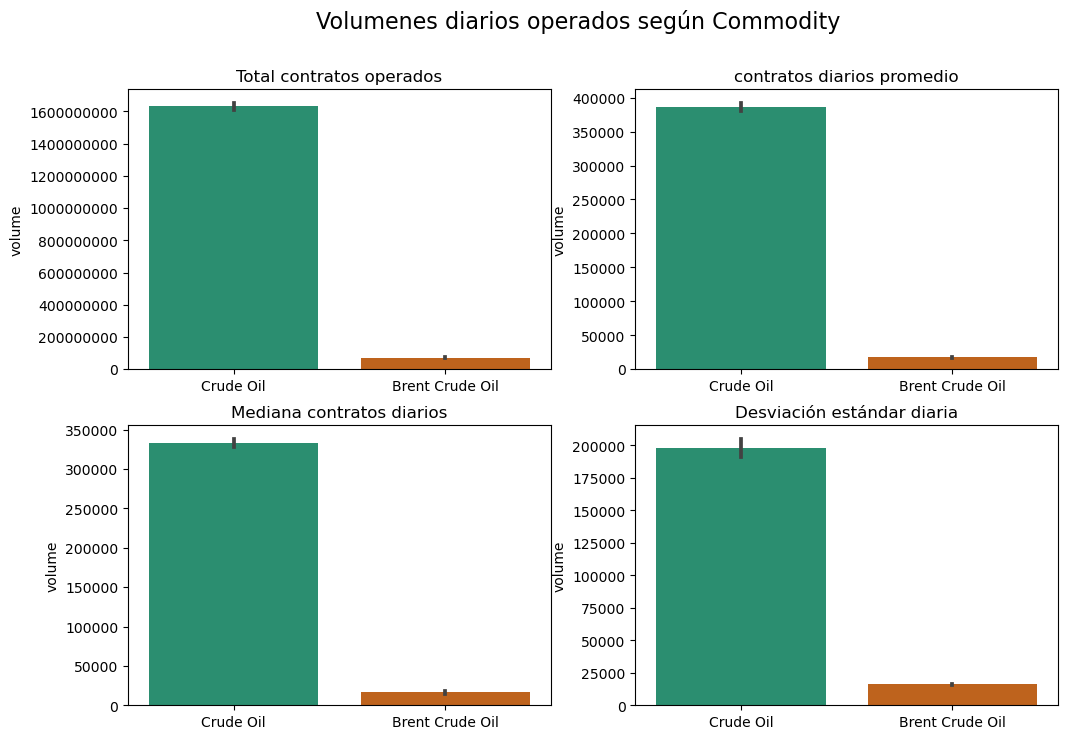

In [144]:
estimators = ["sum", "mean", "median", "std"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, estimator in enumerate(estimators):
    ax = axes[i // 2, i % 2]
    sns.barplot(data=df, x="commodity", y="volume", palette="Dark2", estimator=estimator, ax=ax)
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_xlabel("")
    if i == 0:
        ax.set_title("Total contratos operados")
    elif i == 1:
        ax.set_title("contratos diarios promedio")
    elif i == 2:
        ax.set_title("Mediana contratos diarios")
    elif i == 3:
        ax.set_title("Desviación estándar diaria")
fig.suptitle('Volumenes diarios operados según Commodity', fontsize=16)
plt.show()

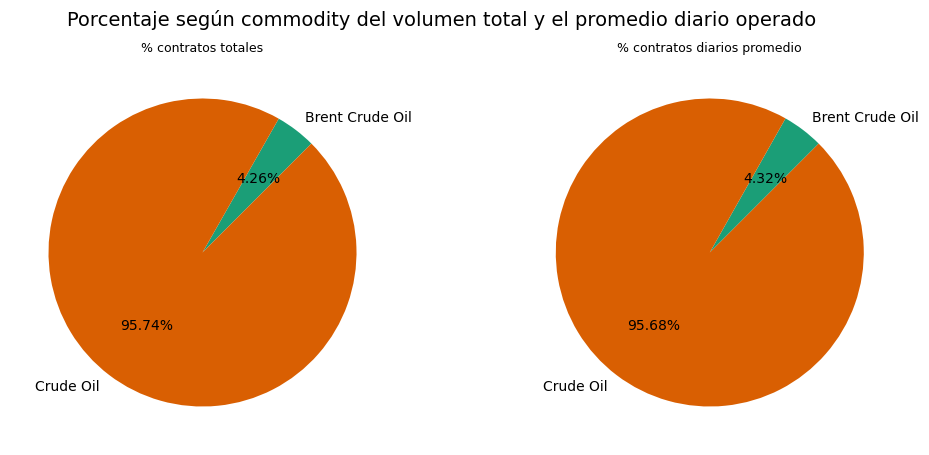

In [145]:
# Porcentaje de contratos Brend Crude Oil y Crude Oil con respecto al total de contratos operados
porc_Brend = (commodity_volume_total['Brent Crude Oil']* 100) / total_volume
porc_Crude = (commodity_volume_total['Crude Oil']* 100) / total_volume

porc_names = ["Brent Crude Oil", "Crude Oil"]
porc_values = [porc_Brend, porc_Crude]

# Porcentaje de contratos diarios promedio Brend Crude Oil y Crude Oil con respecto al total de contratos operados
total_prom_day_volume = commodity_volume_mean.sum()

porc_Brend_prom_day = (commodity_volume_mean['Brent Crude Oil']* 100) / total_prom_day_volume
porc_Crude_prom_day = (commodity_volume_mean['Crude Oil']* 100) / total_prom_day_volume

porc_names_prom_day = ["Brent Crude Oil", "Crude Oil"]
porc_values_prom_day = [porc_Brend_prom_day, porc_Crude_prom_day]

# Gráficamos los porcentajes con pie charts
color = sns.color_palette(palette='Dark2')
fig, axes = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Porcentaje según commodity del volumen total y el promedio diario operado', fontsize=14)
axes[0].pie(porc_values, labels=porc_names, autopct='%1.2f%%', colors = color,
             startangle=45)
axes[0].set_title('% contratos totales', fontsize=9)
axes[1].pie(porc_values_prom_day, labels=porc_names_prom_day, autopct='%1.2f%%', colors = color,
            startangle=45)
axes[1].set_title('% contratos diarios promedio', fontsize=9)
plt.show()

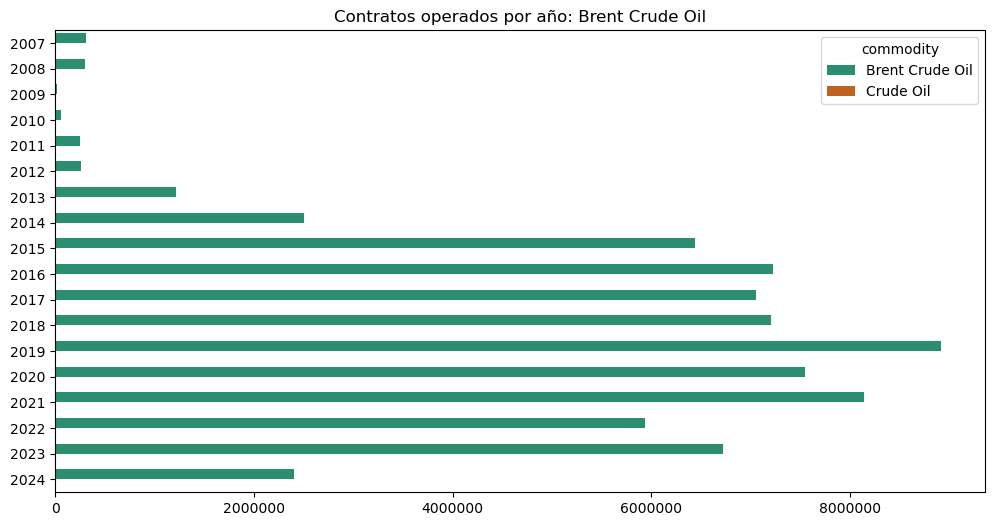

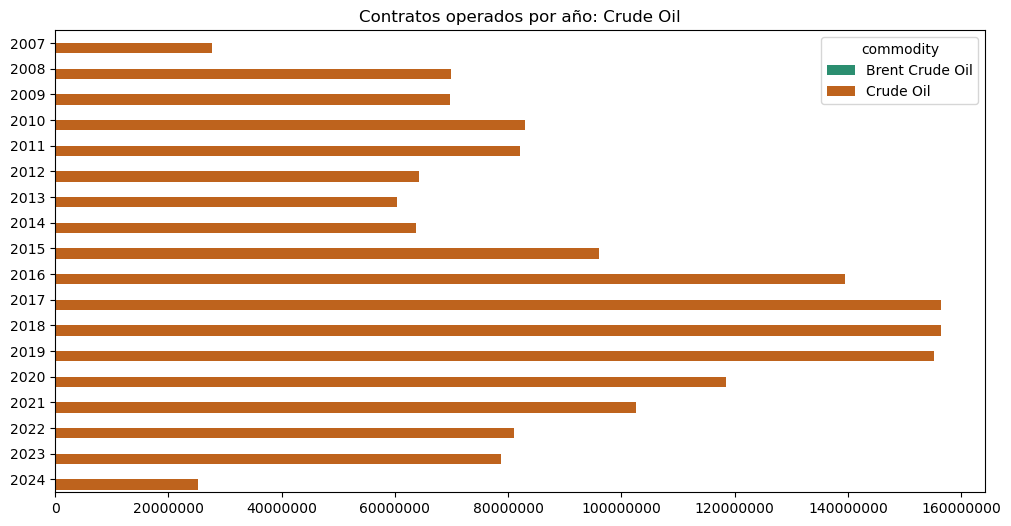

In [146]:
# calculamos los valores totales por año
anual_total_volume = df.groupby('commodity').volume.resample('Y').sum().reset_index()
anual_total_volume['date']=anual_total_volume['date'].apply(lambda x: x.strftime("%Y"))
anual_total_volume=anual_total_volume.sort_values(by='date')

# agrupamos según commodity
grouped_data = anual_total_volume.groupby('commodity')

# Graficamos para cada commodity

for commodity, group_data in grouped_data:
    plt.figure(figsize=(12, 6))
    sns.barplot(x = group_data.volume, y = group_data.date, data=group_data,hue=anual_total_volume.commodity,palette="Dark2")
    plt.title(f'Contratos operados por año: {commodity}')
    plt.ticklabel_format(style='plain', axis='x')
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

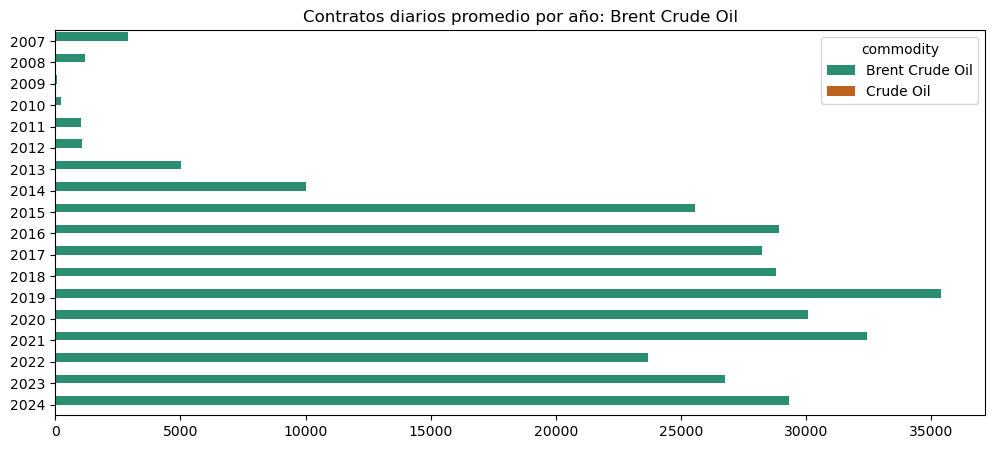

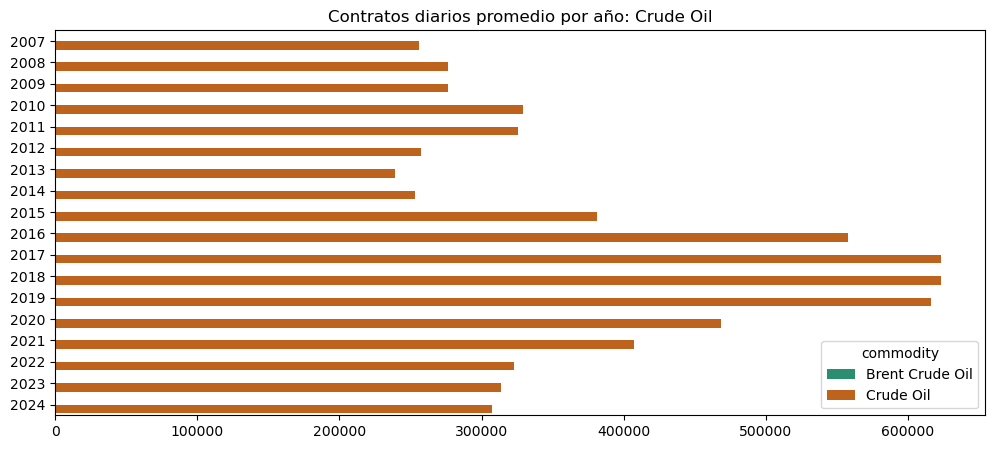

In [163]:
#Contratos diarios promedio por año
anual_mean_daily_volume = df.groupby('commodity').volume.resample('Y').mean().reset_index()
anual_mean_daily_volume['date']=anual_mean_daily_volume['date'].apply(lambda x: x.strftime("%Y"))
anual_mean_daily_volume=anual_mean_daily_volume.sort_values(by='date')

grouped_data = anual_mean_daily_volume.groupby('commodity')

for commodity, group_data in grouped_data:
    plt.figure(figsize=(12, 5))
    sns.barplot(x = group_data.volume, y = group_data.date, data=group_data,hue=anual_total_volume.commodity,palette="Dark2")
    plt.title(f'Contratos diarios promedio por año: {commodity}')
    plt.ticklabel_format(style='plain', axis='x')
    plt.xlabel('')
    plt.ylabel('')
    plt.show()


Como podemos ver la diferencia de los volumnes operados por el WTI y el Brent son muy grandes. Esto se debe en realidad a que el título que nosotros usamos para el Brent es en verdad un activo referenciado.

Mientras los futuros del WTI se comercian principalmente en la Bolsa Mercantil de Nueva York (NYMEX), de donde nosotros tomamos estos datos, en el caso de los futuros del Brent, la principal plaza es el Intercontinental Exchange (ICE) con base en Londres.

Como decíamos, el titulo que nosotros tomamos para analizar el Brent es un activo referciado: nuestro "BZ=F", lo que hace es replica el valor del Brent que se opera en el ICE.

### 4.3. Evolución de los precios de Cierre (close)

In [165]:
df.groupby('commodity').close.describe()

count       mean        std        min        25%  \
commodity                                                             
Brent Crude Oil  4158.0  78.681421  24.806538  19.330000  58.924998   
Crude Oil        4216.0  73.300892  22.850366 -37.630001  53.360001   

                       50%         75%         max  
commodity                                           
Brent Crude Oil  76.680000  101.827501  146.080002  
Crude Oil        73.630001   91.774998  145.289993

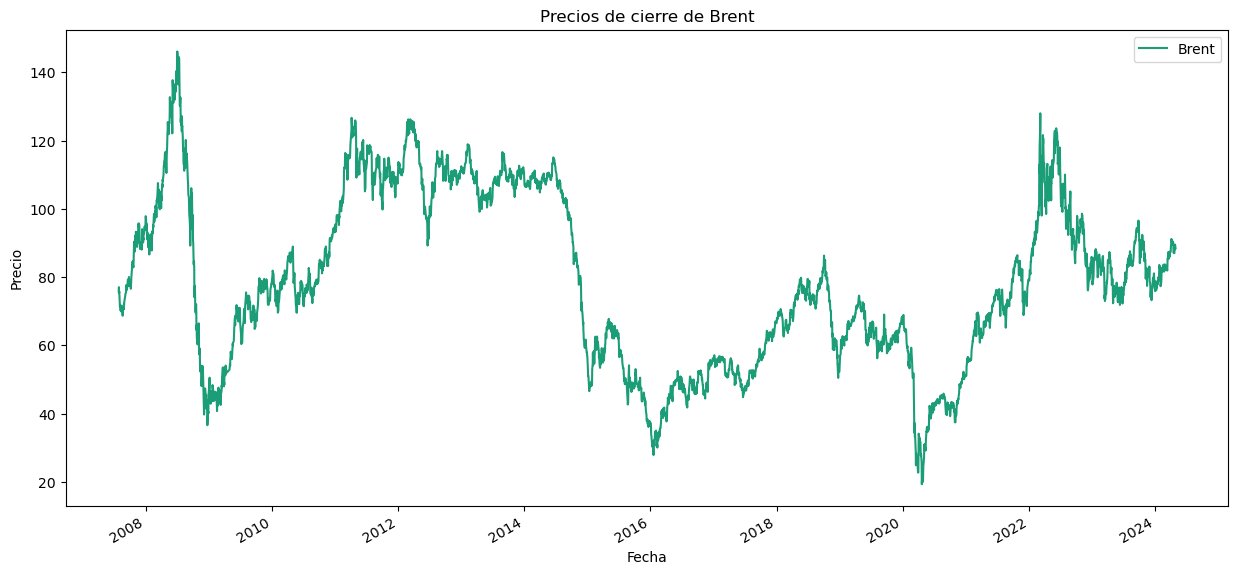

In [166]:
df_brent = df.loc[(df['commodity'] == 'Brent Crude Oil')]

fig, ax=plt.subplots(figsize=(15, 7))
df_brent["close"].plot(ax=ax, label='Brent',color="#1b9e77")
ax.set_title('Precios de cierre de Brent')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.legend();

El primer registro de la serie WTI es 30/07/07 y su último es 29/04/24


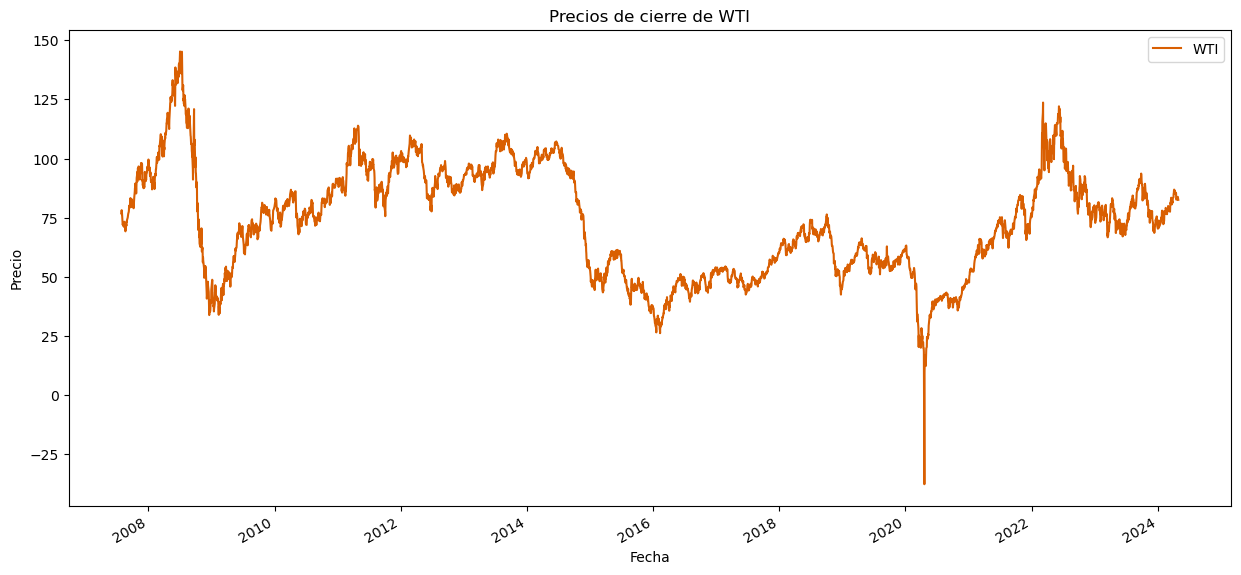

In [167]:
df_wti = df.loc[(df['commodity'] == 'Crude Oil')]
first_date_wti = df_wti.index.min().strftime("%d/%m/%y")
last_date_wti = df_wti.index.max().strftime("%d/%m/%y")

print("El primer registro de la serie WTI es", first_date_wti, "y su último es", last_date_wti)
fig, ax=plt.subplots(figsize=(15, 7))
df_wti["close"].plot(ax=ax, label='WTI',color="#d95f02")
ax.set_title('Precios de cierre de WTI')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.legend();

### 4.4. Volatilidad de Precios (open-high-low-close)

In [168]:
# grafico de velas de los últimos años
yrlimit="2020"

week_brent = df_brent.select_dtypes('float').resample('W').mean().reset_index()
week_brent = week_brent.loc[week_brent['date'] >= yrlimit]
fig = go.Figure(data=[go.Candlestick(x=week_brent['date'],
                open=week_brent['open'],
                high=week_brent['high'],
                low=week_brent['low'],
                close=week_brent['close'])],)
fig.update_layout(
    title="Gráfico de velas de precios de Crudo Brent - Promedios semanales 2020-2024",font=dict(size=15),height=600,margin=dict(l=20, r=20, t=50, b=20)    )
fig.show()
py.plot(fig)

'temp-plot.html'

In [169]:
week_wti = df_wti.select_dtypes('float').resample('W').mean().reset_index()

week_wti = week_wti.loc[week_wti['date'] >= yrlimit]

fig = go.Figure(data=[go.Candlestick(x=week_wti['date'],
                open=week_wti['open'],
                high=week_wti['high'],
                low=week_wti['low'],
                close=week_wti['close'])])
fig.update_layout(title="Gráfico de velas de precios de Crudo WTI - Promedios semanales 2020-2024",font=dict(size=15),height=600,margin=dict(l=20, r=20, t=50, b=20))
fig.show()
py.plot(fig)

'temp-plot.html'

### 4.5. Evolución del Spread entre WTI y Brent

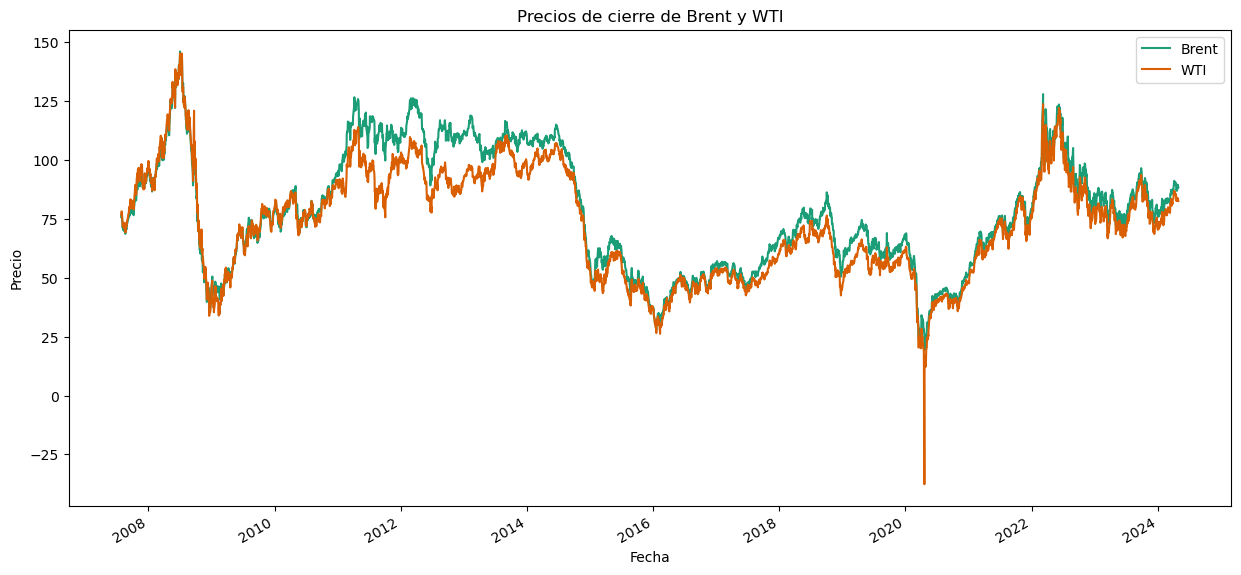

In [170]:
brent_date_mask = (df_wti.index >= df_brent.index.min())
df_wti=df_wti[brent_date_mask]

fig, ax=plt.subplots(figsize=(15, 7))
df_brent["close"].plot(ax=ax, label='Brent',color="#1b9e77")
df_wti["close"].plot(ax=ax, label='WTI',color="#d95f02")
ax.set_title('Precios de cierre de Brent y WTI')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.legend();

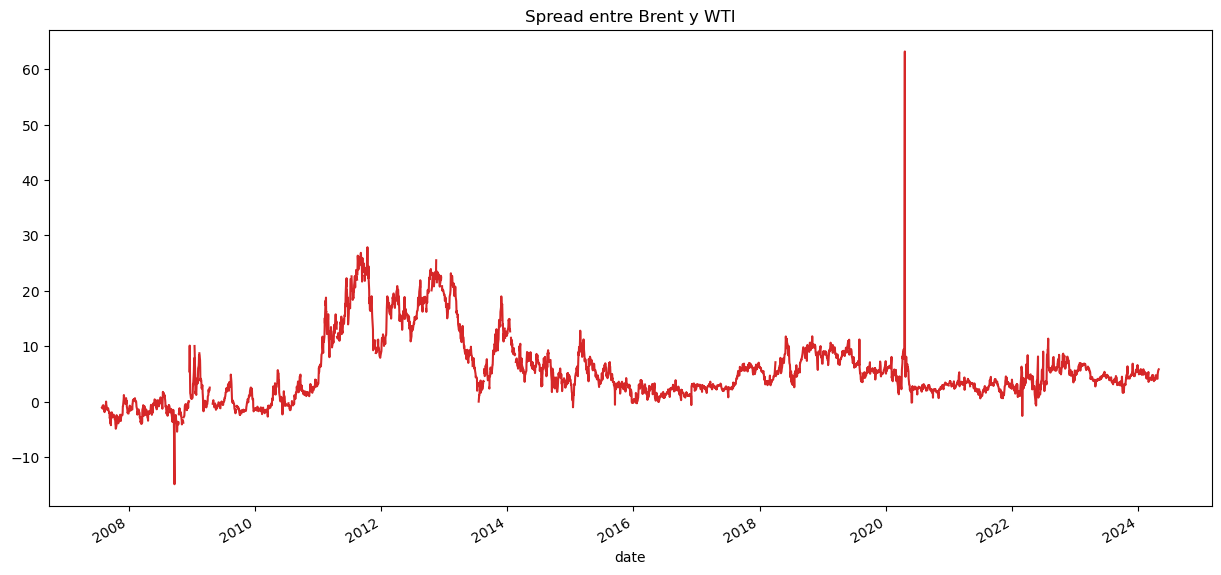

In [171]:
oil_spread = df_brent['close'] - df_wti['close']
oil_spread.plot(figsize=(15, 7),color='tab:red')
plt.title('Spread entre Brent y WTI')
plt.show()

Como vemos, al comienzo de la serie el WTI cotizaba más caro que el Brent. Sin embargo, a partir del 2010 esa tendencia se revirtió: los futuros del Brent pasaron a cotizar por encima de su par norteamericano, y fluctuaron con fuerte volatilidad desde entonces. La emergencia de este nuevo spread y su mayor varianza respecto a los valores históricos generó oportunidades de inversiones de riesgo, que explotan la diferencia de precios entre ambos contratos a futuros a través del arbitraje entre ambos títulos.

La evolución futura de este spread es el principal objetivo de nuestro análisis.


### 4.6. Análisis exploratorio de correlaciones

---



<Axes: >

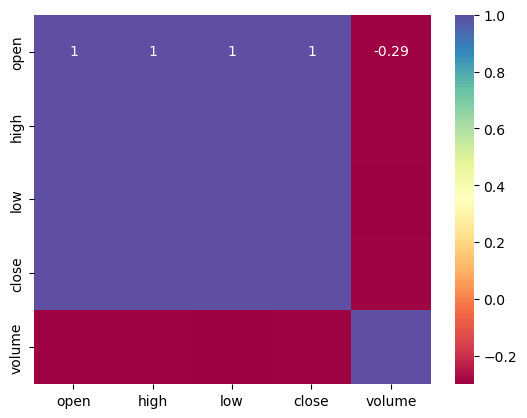

In [172]:
lst = ['open',	'high',	'low',	'close',	'volume']
sns.heatmap(df[lst].corr().round(2), annot=True, cmap='Spectral')

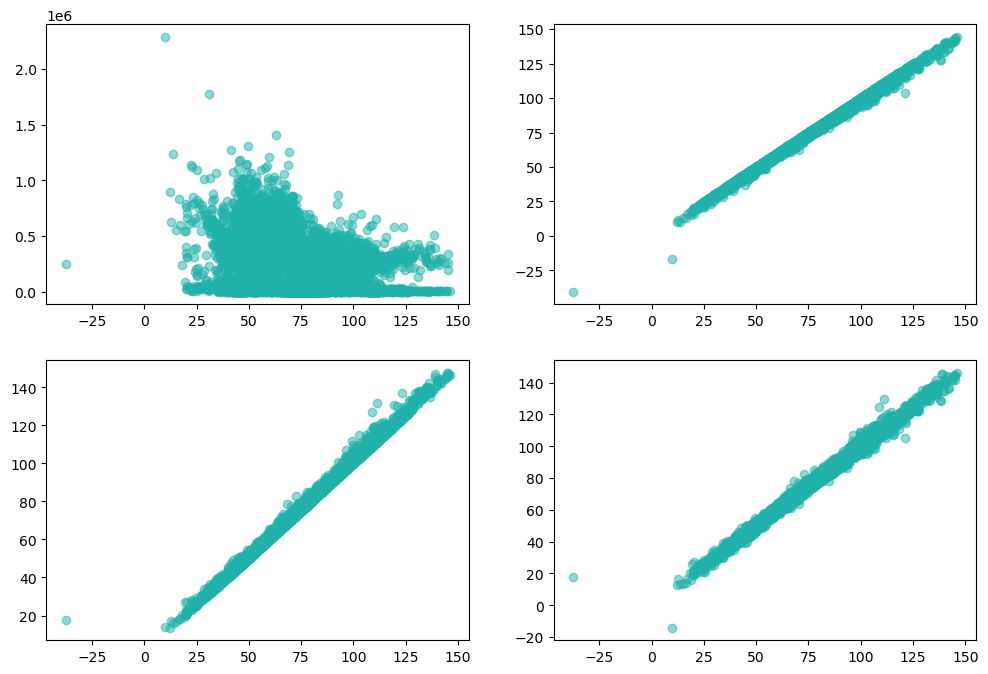

In [173]:
# Realizamos graficos de dispersión

var = 'close'

data = pd.concat([df['volume'], df[var]], axis=1)
data1 = pd.concat([df['low'], df[var]], axis=1)
data2 = pd.concat([df['high'], df[var]], axis=1)
data3 = pd.concat([df['open'], df[var]], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0,0].scatter(x= data['close'], y= data['volume'], c = 'lightseagreen', alpha = 0.5);

axes[0,1].scatter(x= data1['close'], y= data1['low'], c = 'lightseagreen', alpha = 0.5);

axes[1,0].scatter(x= data2['close'], y= data2['high'], c = 'lightseagreen', alpha = 0.5);

axes[1,1].scatter(x= data3['close'], y= data3['open'], c = 'lightseagreen', alpha = 0.5);


# 5. Data Wrangling II

Vamos a unificar la extensión temporal de las dos series, fijando el cominezo de la serie Crude Oil al mismo a la fecha en la que comenzó a operarse el Brent Crude Oil.

In [174]:
df_date_mask = (df.index >= df_brent.index.min())
df=df[df_date_mask]
df

ticker        commodity       open       high        low  \
date                                                                  
2007-07-30   CL=F        Crude Oil  76.949997  77.330002  76.050003   
2007-07-31   CL=F        Crude Oil  76.699997  78.279999  76.599998   
2007-08-01   CL=F        Crude Oil  77.940002  78.769997  76.089996   
2007-08-02   CL=F        Crude Oil  76.739998  77.440002  75.519997   
2007-08-03   CL=F        Crude Oil  76.889999  77.360001  75.040001   
...           ...              ...        ...        ...        ...   
2024-04-23   BZ=F  Brent Crude Oil  87.230003  88.489998  86.040001   
2024-04-24   BZ=F  Brent Crude Oil  88.459999  88.800003  87.650002   
2024-04-25   BZ=F  Brent Crude Oil  88.110001  89.260002  87.290001   
2024-04-26   BZ=F  Brent Crude Oil  89.209999  89.830002  88.800003   
2024-04-29   BZ=F  Brent Crude Oil  88.320000  88.440002  88.320000   

                close  volume       date  
date                                      
2007-07-30  76.830002  189456 2007-07-30  
2007-07-31  78.209999  196464 2007-07-31  
2007-08-01  76.529999  306683 2007-08-01  
2007-08-02  76.860001  214006 2007-08-02  
2007-08-03  75.480003  233021 2007-08-03  
...               ...     ...        ...  
2024-04-23  88.419998   35381 2024-04-23  
2024-04-24  88.019997   26662 2024-04-24  
2024-04-25  89.010002   24588 2024-04-25  
2024-04-26  89.500000   15475 2024-04-26  
2024-04-29  88.440002     107 2024-04-29  

[8374 rows x 8 columns]

In [175]:
df.groupby('commodity').date.min()

commodity
Brent Crude Oil   2007-07-30
Crude Oil         2007-07-30
Name: date, dtype: datetime64[ns]

In [176]:
df.groupby('commodity').date.max()


commodity
Brent Crude Oil   2024-04-29
Crude Oil         2024-04-29
Name: date, dtype: datetime64[ns]

In [177]:
df.groupby('commodity').date.count()

commodity
Brent Crude Oil    4158
Crude Oil          4216
Name: date, dtype: int64

# 6. Análisis Series temporales de `Crude Oil`

## 6.1 Regresión Lineal Múltiple

In [178]:
crude = df['commodity'] == 'Crude Oil'
data_crude_oil = df[crude]
data_crude_oil.ticker.unique()


array(['CL=F'], dtype=object)

In [179]:
# elimino el index
data_crude_oil = data_crude_oil.reset_index(drop=True)
data_crude_oil

ticker  commodity       open       high        low      close  volume  \
0      CL=F  Crude Oil  76.949997  77.330002  76.050003  76.830002  189456   
1      CL=F  Crude Oil  76.699997  78.279999  76.599998  78.209999  196464   
2      CL=F  Crude Oil  77.940002  78.769997  76.089996  76.529999  306683   
3      CL=F  Crude Oil  76.739998  77.440002  75.519997  76.860001  214006   
4      CL=F  Crude Oil  76.889999  77.360001  75.040001  75.480003  233021   
...     ...        ...        ...        ...        ...        ...     ...   
4211   CL=F  Crude Oil  82.129997  83.430000  80.879997  83.360001  355814   
4212   CL=F  Crude Oil  83.400002  83.709999  82.440002  82.809998  329077   
4213   CL=F  Crude Oil  82.830002  83.830002  81.989998  83.570000  314116   
4214   CL=F  Crude Oil  83.809998  84.459999  83.349998  83.849998  244090   
4215   CL=F  Crude Oil  82.760002  82.809998  82.430000  82.589996   12956   

           date  
0    2007-07-30  
1    2007-07-31  
2    2007-08-01  
3    2007-08-02  
4    2007-08-03  
...         ...  
4211 2024-04-23  
4212 2024-04-24  
4213 2024-04-25  
4214 2024-04-26  
4215 2024-04-29  

[4216 rows x 8 columns]

In [180]:
# Elimino las variables que están correlacionadas con close
data_crude_oil = data_crude_oil.drop(['open', 'high', 'low', 'commodity', 'ticker'], axis=1)
data_crude_oil.head(3)

close  volume       date
0  76.830002  189456 2007-07-30
1  78.209999  196464 2007-07-31
2  76.529999  306683 2007-08-01

In [181]:
# Agrupamos por mes y sumamos
data_crude_gb = data_crude_oil.groupby('date')[['close', 'volume']].sum()
data_crude_gb = data_crude_gb.reset_index()
data_crude_gb = data_crude_gb.set_index('date')
data_crude_gb = data_crude_gb[['close','volume']].resample('MS').mean()
data_crude_gb.head(7)

close         volume
date                                
2007-07-01  77.520000  192960.000000
2007-08-01  72.358696  225423.565217
2007-09-01  79.626316  259832.736842
2007-10-01  85.658261  272344.521739
2007-11-01  94.631428  302144.428571
2007-12-01  91.742499  224839.000000
2008-01-01  92.929047  273533.095238

In [182]:
# Creamos una dummy de tiempo
crude_arange = np.arange(len(data_crude_gb['close']))
crude_index = data_crude_gb.index
data_crude_gb["timeIndex"] = pd.Series(crude_arange, index=crude_index)
data_crude_gb.head(3)

close         volume  timeIndex
date                                           
2007-07-01  77.520000  192960.000000          0
2007-08-01  72.358696  225423.565217          1
2007-09-01  79.626316  259832.736842          2

Regresión lineal solo con las variables `close` y `timeIndex`

In [183]:
# Separamos el dataset en train y test
train_r, test_r = train_test_split(data_crude_gb,
                                  test_size=12,
                                  random_state=7,
                                  shuffle=False)

In [184]:
# Ajustamos el modelo lineal
model_linear = smf.ols(formula='close ~ timeIndex', data = train_r).fit()
# Generamos las predicciones para train y test
train_pred = train_r.copy()
test_pred = test_r.copy()
train_pred["LinearTrend"] = model_linear.predict(train_r.timeIndex)
test_pred["LinearTrend"] = model_linear.predict(test_r.timeIndex)

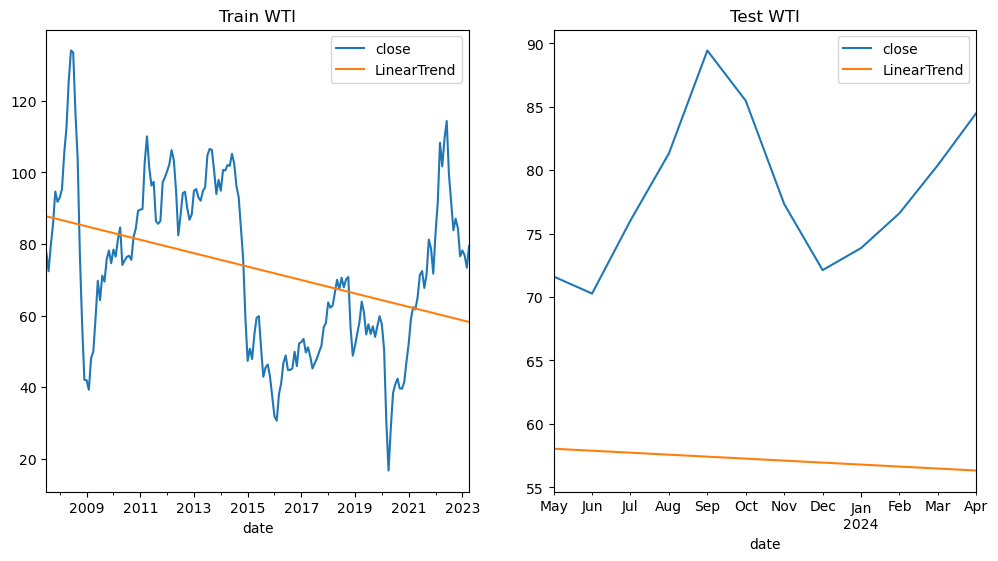

In [185]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","LinearTrend"],ax=axes[0],title='Train WTI');
test_pred.plot(kind = "line", y = ["close","LinearTrend"],ax=axes[1],title='Test WTI');
plt.show()

In [186]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     29.65
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.61e-07
Time:                        14:59:28   Log-Likelihood:                -853.10
No. Observations:                 190   AIC:                             1710.
Df Residuals:                     188   BIC:                             1717.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     87.7111      3.133     27.994      0.000      81.530      93.892
timeIndex     -0.1561      0.029     -5.445      0.000      -0.213      -0.100
==============================================================================
Omnibus:                        5.861   Durbin-Watson:                   0.094
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                3.415
Skew:                           0.109   Prob(JB):                        0.181
Kurtosis:                       2.380   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
data_resultados = pd.DataFrame(columns = ["modelo", "RMSE"])
data_resultados.loc[0, "modelo"] = "Reg Lineal Simple con timeIndex"
data_resultados.loc[0, "RMSE"] = mean_squared_error(test_r.close, test_pred.LinearTrend, squared=False)
data_resultados

modelo       RMSE
0  Reg Lineal Simple con timeIndex  21.893879

Regresión lineal con  `close` como variable target y `timeIndex` y `volume` como variables predictoras

In [188]:
# Ajustamos el modelo lineal
model_linear = smf.ols(formula='close ~ timeIndex + volume', data = train_r).fit()
# Generamos las predicciones para train y test
train_pred["MultReg1"] = model_linear.predict(train_r[['timeIndex','volume']])
test_pred["MultReg1"] = model_linear.predict(test_r[['timeIndex','volume']])

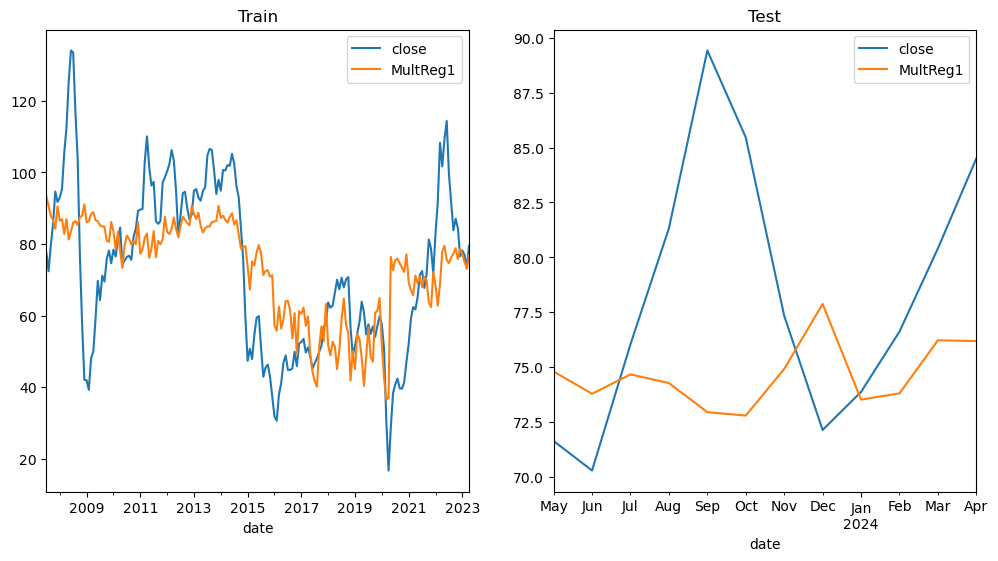

In [189]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","MultReg1"],ax=axes[0],title='Train');
test_pred.plot(kind = "line", y = ["close","MultReg1"],ax=axes[1],title='Test');
plt.show()

In [190]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     53.46
Date:                Thu, 23 May 2024   Prob (F-statistic):           4.33e-19
Time:                        14:59:29   Log-Likelihood:                -824.05
No. Observations:                 190   AIC:                             1654.
Df Residuals:                     187   BIC:                             1664.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    108.9085      3.740     29.121      0.000     101.531     116.286
timeIndex     -0.0454      0.028     -1.612      0.109      -0.101       0.010
volume     -8.106e-05   9.91e-06     -8.178      0.000      -0.000   -6.15e-05
==============================================================================
Omnibus:                        3.680   Durbin-Watson:                   0.187
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.292
Skew:                          -0.308   Prob(JB):                        0.193
Kurtosis:                       3.190   Cond. No.                     1.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [191]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
data_resultados.loc[1, "modelo"] = "Reg Múltiple con timeIndex y volume"
data_resultados.loc[1, "RMSE"] = mean_squared_error(test_r.close, test_pred['MultReg1'], squared=False)
data_resultados

modelo       RMSE
0      Reg Lineal Simple con timeIndex  21.893879
1  Reg Múltiple con timeIndex y volume   7.308234

Regresión lineal con  `close` como variable target y `timeIndex` y `timeIndex` elevado al cuadrado como variables predictoras

In [192]:
# Creamos la variable predictora nueva
data_crude_gb['timeIndex_sq'] = data_crude_gb['timeIndex']**2
data_crude_gb['timeIndex_sq']

date
2007-07-01        0
2007-08-01        1
2007-09-01        4
2007-10-01        9
2007-11-01       16
              ...  
2023-12-01    38809
2024-01-01    39204
2024-02-01    39601
2024-03-01    40000
2024-04-01    40401
Freq: MS, Name: timeIndex_sq, Length: 202, dtype: int32

In [193]:
# Separamos el dataset en train y test
train_r, test_r = train_test_split(data_crude_gb,
                                  test_size=12,
                                  random_state=7,
                                  shuffle=False)

In [194]:
# Ajustamos el modelo lineal
model_quad = smf.ols(formula='close ~ timeIndex + timeIndex_sq', data = train_r).fit()
# Generamos las predicciones para train y test
train_pred = train_r.copy()
test_pred = test_r.copy()
train_pred["QuadraticTrend"] = model_quad.predict(train_r[['timeIndex','timeIndex_sq']])
test_pred["QuadraticTrend"] = model_quad.predict(test_r[['timeIndex','timeIndex_sq']])

<Axes: title={'center': 'Test'}, xlabel='date'>

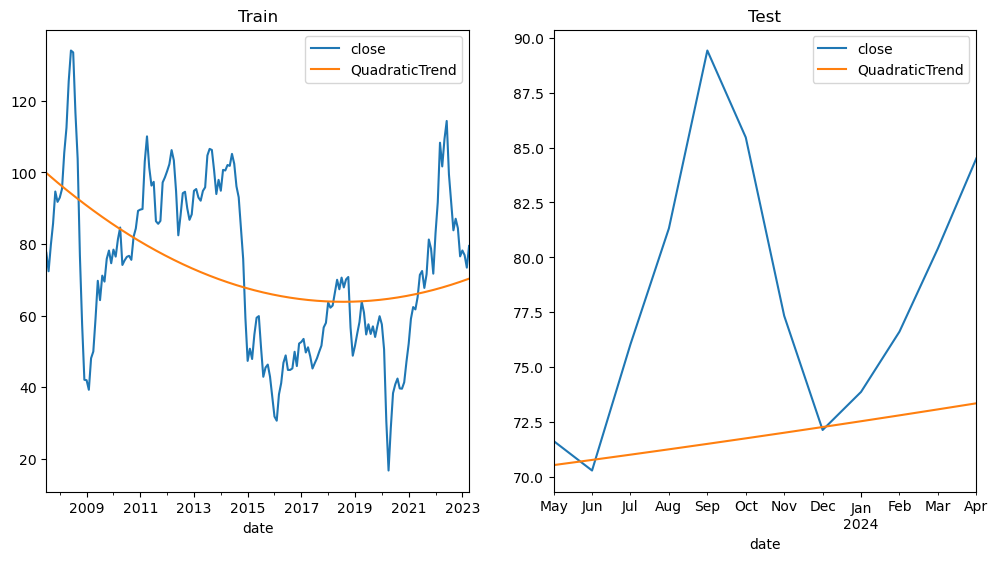

In [195]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","QuadraticTrend"],ax=axes[0],title='Train')
test_pred.plot(kind = "line", y = ["close","QuadraticTrend"],ax=axes[1],title='Test')

In [196]:
model_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     22.25
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.14e-09
Time:                        14:59:30   Log-Likelihood:                -846.73
No. Observations:                 190   AIC:                             1699.
Df Residuals:                     187   BIC:                             1709.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       99.8002      4.527     22.044      0.000      90.869     108.731
timeIndex       -0.5420      0.111     -4.897      0.000      -0.760      -0.324
timeIndex_sq     0.0020      0.001      3.602      0.000       0.001       0.003
==============================================================================
Omnibus:                        4.770   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                2.792
Skew:                           0.006   Prob(JB):                        0.248
Kurtosis:                       2.406   Cond. No.                     4.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [197]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
data_resultados.loc[2, "modelo"] = "timeIndex elevado al cuadrado"
data_resultados.loc[2, "RMSE"] = mean_squared_error(test_r.close, test_pred["QuadraticTrend"], squared=False)
data_resultados

modelo       RMSE
0      Reg Lineal Simple con timeIndex  21.893879
1  Reg Múltiple con timeIndex y volume   7.308234
2        timeIndex elevado al cuadrado   8.476161

Regresión lineal con  `close` como variable target y `timeIndex`, `volume` y `time_volume` como variables predictoras

In [198]:
# Creamos la variable predictora nueva
data_crude_gb['time_volume'] = data_crude_gb['timeIndex']*data_crude_gb['volume']
data_crude_gb['time_volume']

date
2007-07-01    0.000000e+00
2007-08-01    2.254236e+05
2007-09-01    5.196655e+05
2007-10-01    8.170336e+05
2007-11-01    1.208578e+06
                  ...     
2023-12-01    5.371112e+07
2024-01-01    6.452868e+07
2024-02-01    6.404074e+07
2024-03-01    5.827967e+07
2024-04-01    5.855086e+07
Freq: MS, Name: time_volume, Length: 202, dtype: float64

In [199]:
# Separamos el dataset en train y test
train_r, test_r = train_test_split(data_crude_gb,
                                  test_size=12,
                                  random_state=7,
                                  shuffle=False)

In [200]:
# Ajustamos el modelo lineal
model_prod = smf.ols(formula='close ~ timeIndex + volume + time_volume', data = train_r).fit()
# Generamos las predicciones para train y test
train_pred = train_r.copy()
test_pred = test_r.copy()
train_pred["ProductTrend"] = model_prod.predict(train_r[['timeIndex','volume','time_volume']])
test_pred["ProductTrend"] = model_prod.predict(test_r[['timeIndex','volume','time_volume']])

<Axes: title={'center': 'Test'}, xlabel='date'>

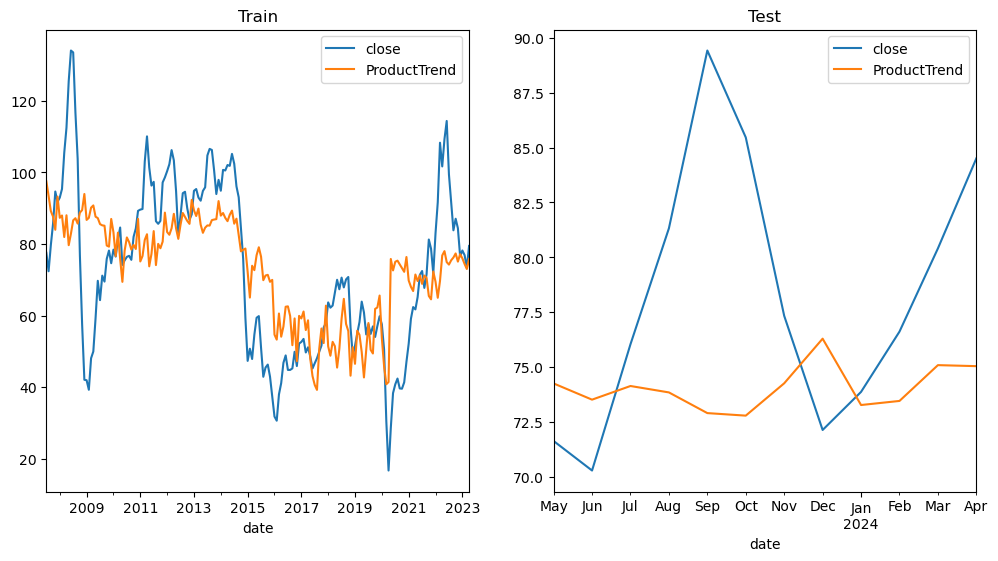

In [201]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","ProductTrend"],ax=axes[0],title='Train')
test_pred.plot(kind = "line", y = ["close","ProductTrend"],ax=axes[1],title='Test')

In [202]:
model_prod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     35.97
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.22e-18
Time:                        14:59:32   Log-Likelihood:                -823.55
No. Observations:                 190   AIC:                             1655.
Df Residuals:                     186   BIC:                             1668.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     121.0314     12.769      9.478      0.000      95.840     146.223
timeIndex      -0.1495      0.109     -1.377      0.170      -0.364       0.065
volume         -0.0001   4.25e-05     -2.873      0.005      -0.000   -3.82e-05
time_volume  3.352e-07   3.38e-07      0.993      0.322   -3.31e-07       1e-06
==============================================================================
Omnibus:                        4.540   Durbin-Watson:                   0.190
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.111
Skew:                          -0.322   Prob(JB):                        0.128
Kurtosis:                       3.324   Cond. No.                     4.87e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [203]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
data_resultados.loc[3, "modelo"] = "Producto entre timeIndex y volume "
data_resultados.loc[3, "RMSE"] = mean_squared_error(test_r.close, test_pred["ProductTrend"], squared=False)
data_resultados

modelo       RMSE
0      Reg Lineal Simple con timeIndex  21.893879
1  Reg Múltiple con timeIndex y volume   7.308234
2        timeIndex elevado al cuadrado   8.476161
3   Producto entre timeIndex y volume    7.454107

Regresión múltiple con estacionalidad

In [204]:
# Creamos columna month
train_r['month'] = [d.strftime('%b') for d in train_r.index]
test_r['month'] = [d.strftime('%b') for d in test_r.index]

In [205]:
# Creamos dummies y devolvemos DataFrames completos
train_r = pd.get_dummies(train_r, columns=['month'], prefix='', prefix_sep='', dtype='int')
test_r = pd.get_dummies(test_r, columns=['month'], prefix='', prefix_sep='', dtype='int')

In [206]:
test_r.columns

Index(['close', 'volume', 'timeIndex', 'timeIndex_sq', 'time_volume', 'Apr',
       'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Sep'],
      dtype='object')

In [207]:
# Generamos un modelo con estacionalidad
variables_y_x = 'close ~ timeIndex + volume + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep'
variables_x = ["timeIndex" ,"volume", "Apr", "Aug", "Dec", "Feb", "Jan", "Jul", "Jun", "Mar", "May", "Nov", "Oct" , "Sep"]
model_est = smf.ols(formula=variables_y_x, data = train_r).fit()
# Generamos las predicciones para train y test
train_pred = train_r.copy()
test_pred = test_r.copy()
train_pred["TrendSeason"] = model_est.predict(train_r[variables_x])
test_pred["TrendSeason"] = model_est.predict(test_r[variables_x])

<Axes: title={'center': 'Test'}, xlabel='date'>

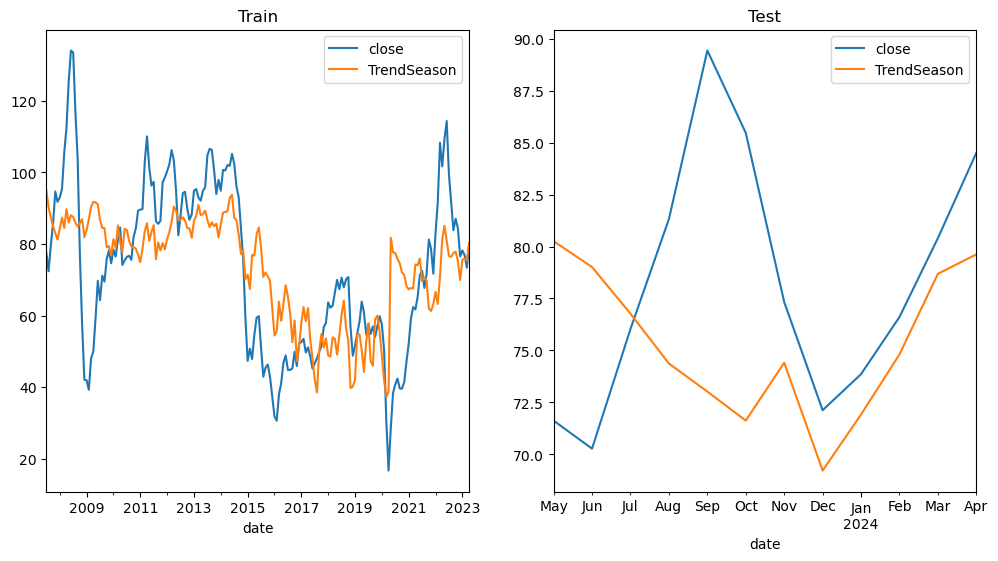

In [208]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","TrendSeason"],ax=axes[0],title='Train')
test_pred.plot(kind = "line", y = ["close","TrendSeason"],ax=axes[1],title='Test')

In [209]:
model_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     8.564
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.33e-13
Time:                        14:59:33   Log-Likelihood:                -820.45
No. Observations:                 190   AIC:                             1669.
Df Residuals:                     176   BIC:                             1714.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.3323      3.521     28.777      0.000      94.383     108.282
timeIndex     -0.0415      0.029     -1.455      0.147      -0.098       0.015
volume     -8.408e-05   1.02e-05     -8.277      0.000      -0.000    -6.4e-05
Apr           11.1308      4.537      2.453      0.015       2.177      20.085
Aug            7.9107      4.522      1.749      0.082      -1.013      16.835
Dec           -1.0033      4.539     -0.221      0.825      -9.962       7.956
Feb            8.8023      4.553      1.933      0.055      -0.183      17.788
Jan            6.2126      4.537      1.369      0.173      -2.742      15.168
Jul            9.9011      4.520      2.191      0.030       0.981      18.821
Jun           13.0680      4.666      2.800      0.006       3.859      22.277
Mar           10.1646      4.540      2.239      0.026       1.204      19.125
May           13.2655      4.679      2.835      0.005       4.031      22.501
Nov            7.2614      4.536      1.601      0.111      -1.690      16.213
Oct            6.6902      4.522      1.479      0.141      -2.234      15.615
Sep            7.9284      4.524      1.752      0.081      -1.000      16.857
==============================================================================
Omnibus:                        7.175   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.054
Skew:                          -0.467   Prob(JB):                       0.0294
Kurtosis:                       3.134   Cond. No.                     4.60e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.59e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [210]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
data_resultados.loc[4, "modelo"] = "Incluyendo estacionalidad"
data_resultados.loc[4, "RMSE"] = mean_squared_error(test_r.close, test_pred["TrendSeason"], squared=False)
data_resultados

modelo       RMSE
0      Reg Lineal Simple con timeIndex  21.893879
1  Reg Múltiple con timeIndex y volume   7.308234
2        timeIndex elevado al cuadrado   8.476161
3   Producto entre timeIndex y volume    7.454107
4            Incluyendo estacionalidad   7.699968

Observación: El mejor resultado se obtuvo cuando se agregó el producto entre las variables `timeIndex`y `volume`. Si bien este resultado no es mejor que la regresión lineal simple porque tiene un RMSE más alto, se obtuvo un mayor valor para el R-ajustado.

## 6.2 Tendencia con Transformación Logarítmica

In [211]:
df[crude]

ticker  commodity       open       high        low      close  \
date                                                                       
2007-07-30   CL=F  Crude Oil  76.949997  77.330002  76.050003  76.830002   
2007-07-31   CL=F  Crude Oil  76.699997  78.279999  76.599998  78.209999   
2007-08-01   CL=F  Crude Oil  77.940002  78.769997  76.089996  76.529999   
2007-08-02   CL=F  Crude Oil  76.739998  77.440002  75.519997  76.860001   
2007-08-03   CL=F  Crude Oil  76.889999  77.360001  75.040001  75.480003   
...           ...        ...        ...        ...        ...        ...   
2024-04-23   CL=F  Crude Oil  82.129997  83.430000  80.879997  83.360001   
2024-04-24   CL=F  Crude Oil  83.400002  83.709999  82.440002  82.809998   
2024-04-25   CL=F  Crude Oil  82.830002  83.830002  81.989998  83.570000   
2024-04-26   CL=F  Crude Oil  83.809998  84.459999  83.349998  83.849998   
2024-04-29   CL=F  Crude Oil  82.760002  82.809998  82.430000  82.589996   

            volume       date  
date                           
2007-07-30  189456 2007-07-30  
2007-07-31  196464 2007-07-31  
2007-08-01  306683 2007-08-01  
2007-08-02  214006 2007-08-02  
2007-08-03  233021 2007-08-03  
...            ...        ...  
2024-04-23  355814 2024-04-23  
2024-04-24  329077 2024-04-24  
2024-04-25  314116 2024-04-25  
2024-04-26  244090 2024-04-26  
2024-04-29   12956 2024-04-29  

[4216 rows x 8 columns]

In [212]:
df_crude_oil = df[crude]
df_crude_oil.ticker.unique()

array(['CL=F'], dtype=object)

In [213]:
# elimino el index
df_crude_oil = df_crude_oil.reset_index(drop=True)
df_crude_oil

ticker  commodity       open       high        low      close  volume  \
0      CL=F  Crude Oil  76.949997  77.330002  76.050003  76.830002  189456   
1      CL=F  Crude Oil  76.699997  78.279999  76.599998  78.209999  196464   
2      CL=F  Crude Oil  77.940002  78.769997  76.089996  76.529999  306683   
3      CL=F  Crude Oil  76.739998  77.440002  75.519997  76.860001  214006   
4      CL=F  Crude Oil  76.889999  77.360001  75.040001  75.480003  233021   
...     ...        ...        ...        ...        ...        ...     ...   
4211   CL=F  Crude Oil  82.129997  83.430000  80.879997  83.360001  355814   
4212   CL=F  Crude Oil  83.400002  83.709999  82.440002  82.809998  329077   
4213   CL=F  Crude Oil  82.830002  83.830002  81.989998  83.570000  314116   
4214   CL=F  Crude Oil  83.809998  84.459999  83.349998  83.849998  244090   
4215   CL=F  Crude Oil  82.760002  82.809998  82.430000  82.589996   12956   

           date  
0    2007-07-30  
1    2007-07-31  
2    2007-08-01  
3    2007-08-02  
4    2007-08-03  
...         ...  
4211 2024-04-23  
4212 2024-04-24  
4213 2024-04-25  
4214 2024-04-26  
4215 2024-04-29  

[4216 rows x 8 columns]

In [214]:
# Pasamos de Series a DataFrame y luego agrupamos por mes
crude_gb_sum = df_crude_oil.groupby('date')['close'].sum()
crude_gb = crude_gb_sum.reset_index()
crude_gb = crude_gb.set_index('date')
y_crude = crude_gb['close'].resample('MS').mean()

<Figure size 600x600 with 0 Axes>

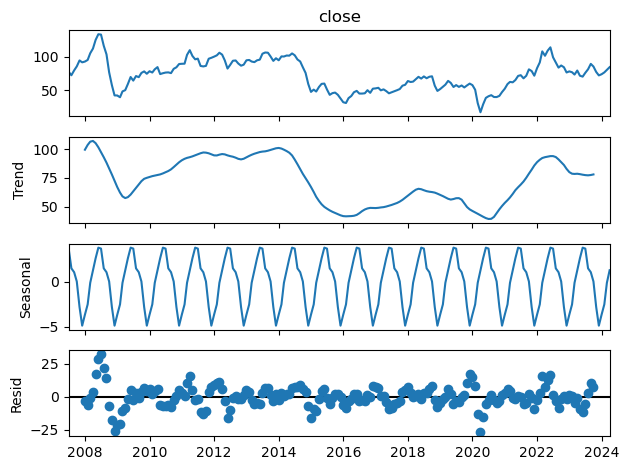

In [215]:
# Descomponemos la serie temporal en sus componentes de tendencia, estacionalidad y residuos
figsize = (6,6)
plt.figure(figsize=figsize)
decomposition_model = 'additive'
decomposition_crude = sm.tsa.seasonal_decompose(y_crude, model=decomposition_model)
decomposition_crude.plot();

In [216]:
# Pasamos valores a comienzo de mes y utilizamos la media
crude_gb = crude_gb['close'].resample('MS').mean().to_frame()
crude_gb.head(3)

close
date                 
2007-07-01  77.520000
2007-08-01  72.358696
2007-09-01  79.626316

In [217]:
# Creamos una dummy de tiempo
crude_arange = np.arange(len(crude_gb['close']))
crude_index = crude_gb.index
crude_gb["timeIndex"] = pd.Series(crude_arange, index=crude_index)
crude_gb.head(3)

close  timeIndex
date                            
2007-07-01  77.520000          0
2007-08-01  72.358696          1
2007-09-01  79.626316          2

In [218]:
# Dividimos el dataset en train y test y no mezclamos las observaciones
test_size = 12; random_state = 7; shuffle = False
df_train_c, df_test_c = train_test_split(crude_gb, test_size=test_size, random_state=random_state, shuffle=shuffle)

In [219]:
# Verificamos los últimos datos de df_train
df_train_c.tail(2)

close  timeIndex
date                            
2023-03-01  73.372609        188
2023-04-01  79.438422        189

In [220]:
# Verificamos los primeros datos de df_test
df_test_c.head(2)

close  timeIndex
date                            
2023-05-01  71.620909        190
2023-06-01  70.274285        191

In [221]:
# Hacemos una transformación logarítmica
train_log_c = np.log(df_train_c['close'])
test_log_c = np.log(df_test_c['close'])

df_train_c['log_close'] = train_log_c
df_test_c['log_close'] = test_log_c

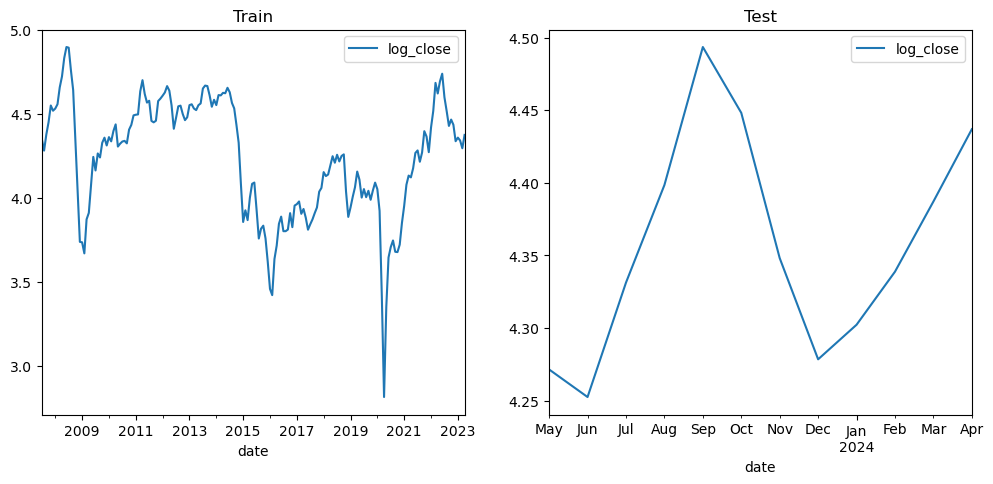

In [222]:
# Graficamos
n_rows = 1; n_cols = 2; figsize = (12,5)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
kind = 'line'; title_train = 'Train'; title_test = 'Test'; ax0 = axes[0]; ax1 = axes[1]; log_c = ['log_close']
df_train_c.plot(kind='line', y=log_c, ax=ax0, title=title_train);
df_test_c.plot(kind='line', y=log_c, ax=ax1, title=title_test);

In [223]:
# Generamos un modelo de regresión lineal usando el logaritmo del valor 'close' de Crude Oil
crude_ols_y_x = 'log_close ~ timeIndex'
model_ols_log_c = smf.ols(crude_ols_y_x, data=df_train_c)
model_log_c = model_ols_log_c.fit()

In [224]:
# Predecimos
train_timeIndex_c = df_train_c[["timeIndex"]]
test_timeIndex_c = df_test_c[["timeIndex"]]

df_train_c["LogTrend"] = model_log_c.predict(train_timeIndex_c)
df_test_c["LogTrend"] = model_log_c.predict(test_timeIndex_c)

In [225]:
# Restauramos el valor predicho de close al aplicar la función exponencial
train_exp_c = np.exp(df_train_c['LogTrend'])
test_exp_c = np.exp(df_test_c['LogTrend'])

df_train_c['back_LogTrend'] = train_exp_c
df_test_c['back_LogTrend'] = test_exp_c

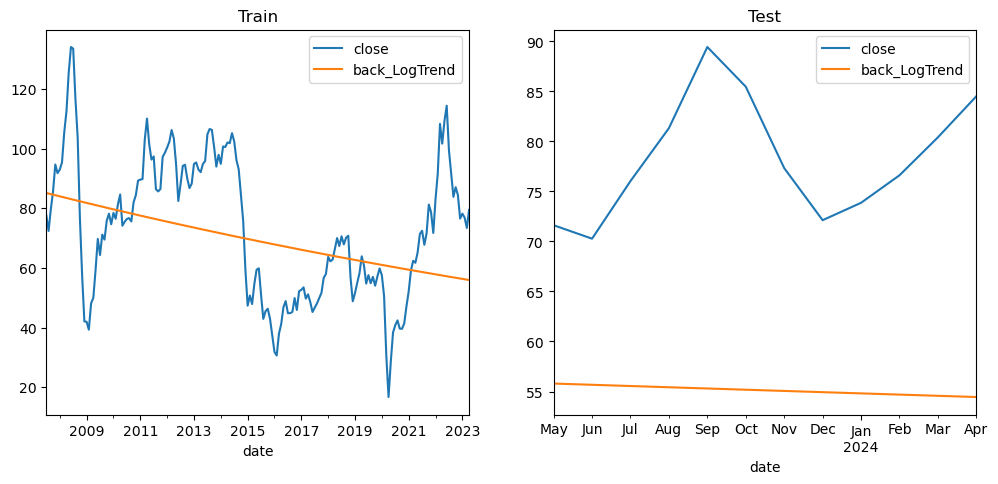

In [226]:
# Comparamos el valor de close con el valor real
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
y = ["close","back_LogTrend"]; ax0 = axes[0]; ax1 = axes[1]
df_train_c.plot(kind='line', y=y, ax=ax0, title=title_train);
df_test_c.plot(kind='line', y=y, ax=ax1, title=title_test);

In [227]:
# Calculamos la performance con RMSE
root = False
crude_test_close = df_test_c['close']
crude_test_back_LogTrend = df_test_c['back_LogTrend']
crude_log_rmse = mean_squared_error(crude_test_close, crude_test_back_LogTrend, squared=root)
crude_dict = {'modelo':['Tendencia con Transformación Logarítmica'], 'RMSE':[crude_log_rmse]}
performance_df_c = pd.DataFrame(crude_dict)
print(f'RMSE: {crude_log_rmse}')

RMSE: 23.87755119148942


In [228]:
crude_dict

{'modelo': ['Tendencia con Transformación Logarítmica'],
 'RMSE': [23.87755119148942]}

In [229]:
model_log_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_close   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     26.41
Date:                Thu, 23 May 2024   Prob (F-statistic):           6.90e-07
Time:                        14:59:38   Log-Likelihood:                -56.080
No. Observations:                 190   AIC:                             116.2
Df Residuals:                     188   BIC:                             122.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4437      0.047     94.093      0.000       4.351       4.537
timeIndex     -0.0022      0.000     -5.139      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       12.165   Durbin-Watson:                   0.123
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.597
Skew:                          -0.591   Prob(JB):                      0.00184
Kurtosis:                       3.440   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 6.3 Transformación Logarítmica + Estacionalidad Mensual

In [230]:
df_train_c

close  timeIndex  log_close  LogTrend  back_LogTrend
date                                                                
2007-07-01  77.520000          0   4.350536  4.443711      85.090167
2007-08-01  72.358696          1   4.281636  4.441490      84.901384
2007-09-01  79.626316          2   4.377345  4.439269      84.713019
2007-10-01  85.658261          3   4.450366  4.437048      84.525072
2007-11-01  94.631428          4   4.549990  4.434827      84.337542
...               ...        ...        ...       ...            ...
2022-12-01  76.518095        185   4.337527  4.032809      56.419169
2023-01-01  78.164000        186   4.358809  4.030588      56.293996
2023-02-01  76.860526        187   4.341992  4.028367      56.169100
2023-03-01  73.372609        188   4.295551  4.026146      56.044482
2023-04-01  79.438422        189   4.374982  4.023925      55.920140

[190 rows x 5 columns]

In [231]:
# Creamos columna month
crude_index_train = df_train_c.index
crude_index_test = df_test_c.index

df_train_c['month'] = [d.strftime('%b') for d in crude_index_train]

In [232]:
df_test_c['month']  = [d.strftime('%b') for d in crude_index_test]

In [233]:
# Creamos dummies y devolvemos DataFrames completos
df_train_c = pd.get_dummies(df_train_c, columns=['month'], prefix='', prefix_sep='', dtype='int')
df_test_c = pd.get_dummies(df_test_c, columns=['month'], prefix='', prefix_sep='', dtype='int')

In [234]:
# Verificamos las columnas
df_train_c.columns

Index(['close', 'timeIndex', 'log_close', 'LogTrend', 'back_LogTrend', 'Apr',
       'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Sep'],
      dtype='object')

In [235]:
# Verificamos el DataFrame
df_train_c.head(3)

close  timeIndex  log_close  LogTrend  back_LogTrend  Apr  \
date                                                                        
2007-07-01  77.520000          0   4.350536  4.443711      85.090167    0   
2007-08-01  72.358696          1   4.281636  4.441490      84.901384    0   
2007-09-01  79.626316          2   4.377345  4.439269      84.713019    0   

            Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  Sep  
date                                                               
2007-07-01    0    0    0    0    1    0    0    0    0    0    0  
2007-08-01    1    0    0    0    0    0    0    0    0    0    0  
2007-09-01    0    0    0    0    0    0    0    0    0    0    1

In [236]:
# Generamos un modelo
crude_ols_est_y_x = 'log_close ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep'
model_log_est_c = smf.ols(crude_ols_est_y_x, data=df_train_c).fit()

In [237]:
df_train_c

close  timeIndex  log_close  LogTrend  back_LogTrend  Apr  \
date                                                                        
2007-07-01  77.520000          0   4.350536  4.443711      85.090167    0   
2007-08-01  72.358696          1   4.281636  4.441490      84.901384    0   
2007-09-01  79.626316          2   4.377345  4.439269      84.713019    0   
2007-10-01  85.658261          3   4.450366  4.437048      84.525072    0   
2007-11-01  94.631428          4   4.549990  4.434827      84.337542    0   
...               ...        ...        ...       ...            ...  ...   
2022-12-01  76.518095        185   4.337527  4.032809      56.419169    0   
2023-01-01  78.164000        186   4.358809  4.030588      56.293996    0   
2023-02-01  76.860526        187   4.341992  4.028367      56.169100    0   
2023-03-01  73.372609        188   4.295551  4.026146      56.044482    0   
2023-04-01  79.438422        189   4.374982  4.023925      55.920140    1   

            Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  Sep  
date                                                               
2007-07-01    0    0    0    0    1    0    0    0    0    0    0  
2007-08-01    1    0    0    0    0    0    0    0    0    0    0  
2007-09-01    0    0    0    0    0    0    0    0    0    0    1  
2007-10-01    0    0    0    0    0    0    0    0    0    1    0  
2007-11-01    0    0    0    0    0    0    0    0    1    0    0  
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2022-12-01    0    1    0    0    0    0    0    0    0    0    0  
2023-01-01    0    0    0    1    0    0    0    0    0    0    0  
2023-02-01    0    0    1    0    0    0    0    0    0    0    0  
2023-03-01    0    0    0    0    0    0    1    0    0    0    0  
2023-04-01    0    0    0    0    0    0    0    0    0    0    0  

[190 rows x 17 columns]

In [238]:
df_test_c

close  timeIndex  log_close  LogTrend  back_LogTrend  Apr  \
date                                                                        
2023-05-01  71.620909        190   4.271387  4.021704      55.796074    0   
2023-06-01  70.274285        191   4.252406  4.019482      55.672283    0   
2023-07-01  76.034500        192   4.331187  4.017261      55.548767    0   
2023-08-01  81.320870        193   4.398403  4.015040      55.425525    0   
2023-09-01  89.430500        194   4.493462  4.012819      55.302556    0   
2023-10-01  85.466818        195   4.448128  4.010598      55.179860    0   
2023-11-01  77.330000        196   4.348082  4.008377      55.057436    0   
2023-12-01  72.123500        197   4.278380  4.006156      54.935284    0   
2024-01-01  73.860952        198   4.302184  4.003935      54.813403    0   
2024-02-01  76.610000        199   4.338728  4.001714      54.691793    0   
2024-03-01  80.405000        200   4.387076  3.999493      54.570452    0   
2024-04-01  84.509524        201   4.436864  3.997271      54.449380    1   

            Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  Sep  
date                                                               
2023-05-01    0    0    0    0    0    0    0    1    0    0    0  
2023-06-01    0    0    0    0    0    1    0    0    0    0    0  
2023-07-01    0    0    0    0    1    0    0    0    0    0    0  
2023-08-01    1    0    0    0    0    0    0    0    0    0    0  
2023-09-01    0    0    0    0    0    0    0    0    0    0    1  
2023-10-01    0    0    0    0    0    0    0    0    0    1    0  
2023-11-01    0    0    0    0    0    0    0    0    1    0    0  
2023-12-01    0    1    0    0    0    0    0    0    0    0    0  
2024-01-01    0    0    0    1    0    0    0    0    0    0    0  
2024-02-01    0    0    1    0    0    0    0    0    0    0    0  
2024-03-01    0    0    0    0    0    0    1    0    0    0    0  
2024-04-01    0    0    0    0    0    0    0    0    0    0    0

In [239]:
# Predecimos
cols_log_est_c = ["timeIndex", "Apr", "Aug", "Dec", "Feb", "Jan", "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]

df_train_c['model_log_est'] = model_log_est_c.predict(df_train_c[cols_log_est_c])
df_test_c['model_log_est'] = model_log_est_c.predict(df_test_c[cols_log_est_c])

In [240]:
# Aplicamos la función exponencial
df_train_c['back_LogEstTrend'] = np.exp(df_train_c['model_log_est'])
df_test_c['back_LogEstTrend'] = np.exp(df_test_c['model_log_est'])

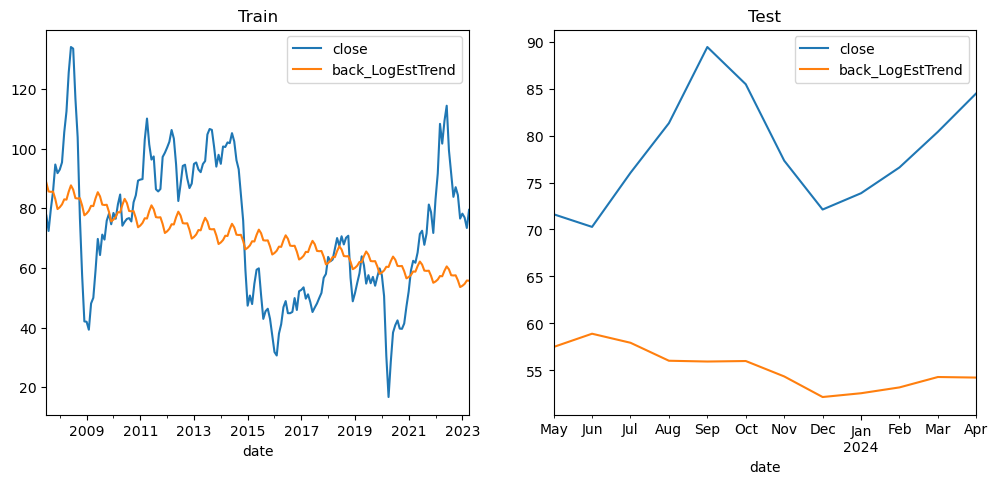

In [241]:
# Graficamos
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
y = ["close","back_LogEstTrend"]; ax0 = axes[0]; ax1 = axes[1]
df_train_c.plot(kind='line', y=y, ax=axes[0], title=title_train);
df_test_c.plot(kind='line', y=y, ax=axes[1], title=title_test);

In [242]:
model_log_est_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_close   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.227
Date:                Thu, 23 May 2024   Prob (F-statistic):             0.0123
Time:                        14:59:39   Log-Likelihood:                -55.206
No. Observations:                 190   AIC:                             136.4
Df Residuals:                     177   BIC:                             178.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1012      0.045     91.618      0.000       4.013       4.190
timeIndex     -0.0022      0.000     -4.975      0.000      -0.003      -0.001
Apr            0.3359      0.080      4.174      0.000       0.177       0.495
Aug            0.3507      0.080      4.367      0.000       0.192       0.509
Dec            0.2881      0.080      3.585      0.000       0.130       0.447
Feb            0.3120      0.080      3.880      0.000       0.153       0.471
Jan            0.2980      0.080      3.707      0.000       0.139       0.457
Jul            0.3821      0.080      4.759      0.000       0.224       0.541
Jun            0.3964      0.083      4.788      0.000       0.233       0.560
Mar            0.3348      0.080      4.162      0.000       0.176       0.494
May            0.3700      0.083      4.469      0.000       0.207       0.533
Nov            0.3271      0.080      4.071      0.000       0.169       0.486
Oct            0.3546      0.080      4.414      0.000       0.196       0.513
Sep            0.3514      0.080      4.375      0.000       0.193       0.510
==============================================================================
Omnibus:                       11.654   Durbin-Watson:                   0.118
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.005
Skew:                          -0.592   Prob(JB):                      0.00247
Kurtosis:                       3.337   Cond. No.                     1.20e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.57e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [243]:
# Calculamos la performance con el RMSE
crude_log_est_rmse = mean_squared_error(df_test_c['close'], df_test_c['back_LogEstTrend'], squared=root)
crude_log_est_rmse

23.833538347524964

In [244]:
# Comparamos con el modelo anterior
performance_df_c.loc[1] = ['Transformación Logarítmica + Estacionalidad Mensual', crude_log_est_rmse]
performance_df_c

modelo       RMSE
0           Tendencia con Transformación Logarítmica  23.877551
1  Transformación Logarítmica + Estacionalidad Me...  23.833538

## 6.4 ARIMA

In [245]:
# Utilizamos el test de Dickey-Fuller aumentado para detectar series estacionarias
adfuller_c = adfuller(df_train_c['close'])
print(f'ADF Statistic: {adfuller_c[0]}\np-value: {adfuller_c[1]}')
for key, value in adfuller_c[4].items():
    print(f'Valor crítico {key}: {value:.2f}')

ADF Statistic: -2.972424897274076
p-value: 0.03755105072671263
Valor crítico 1%: -3.47
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


El p-value es ligeramente mayor a 0.05, por lo tanto no es estacionaria. Aplicaremos ADF al residuo de la serie entre el valor de 'close' original y el del modelo anterior.

Text(0.5, 1.0, 'Residuo')

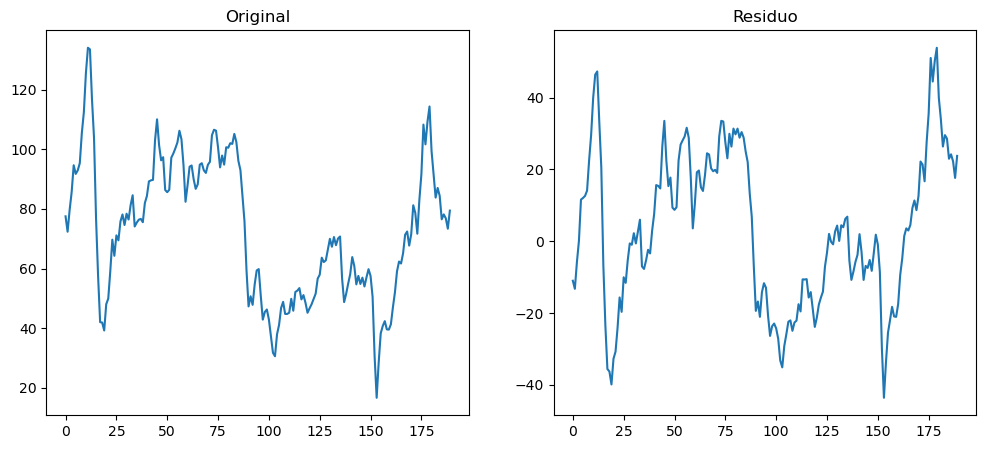

In [246]:
# Calculamos y graficamos el original contra el residuo
res_model_c = df_train_c['close'] - df_train_c['back_LogEstTrend']

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
ti = df_train_c['timeIndex']; close = df_train_c['close']; ax0 = axes[0]; ax1 = axes[1]; original = 'Original'; residuo = 'Residuo'
ax0.plot(ti, close); ax0.set_title(original)
ax1.plot(ti, res_model_c); ax1.set_title(residuo)

In [247]:
# Aplicamos el test de Dickey-Fuller aumentado al residuo
adf_resid_c = adfuller(res_model_c)
print(f'ADF Statistic: {adf_resid_c[0]}\np-value: {adf_resid_c[1]}')
for key, value in adf_resid_c[4].items():
    print(f'Valor crítico {key}: {value:.2f}')

ADF Statistic: -3.094343970538752
p-value: 0.026974601376538055
Valor crítico 1%: -3.47
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


El p-value empeoró, por lo tanto aplicaremos diferenciación.

In [248]:
df_train_c['close_diff'] = df_train_c['close'].diff()
cf_c = df_train_c['close_diff'].dropna()
adf_diff_c = adfuller(cf_c)
print(f'ADF Statistic: {adf_diff_c[0]}\np-value: {adf_diff_c[1]:.3f}')
for key, value in adf_diff_c[4].items():
    print(f'Valor crítico {key}: {value:.2f}')

ADF Statistic: -9.13902095444153
p-value: 0.000
Valor crítico 1%: -3.47
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


Ahora que la serie es estacionaria, obtenemos p y q.

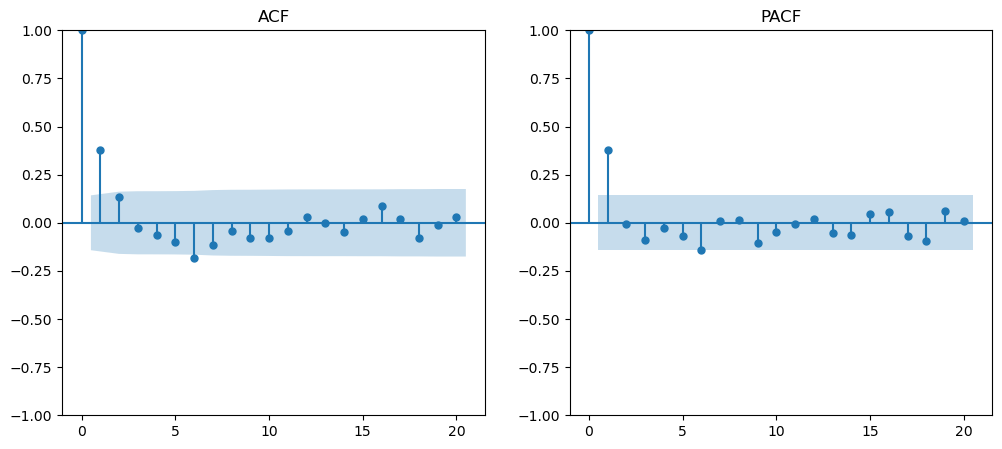

In [249]:
# Determinamos p y q con ACF y PACF
fig, axes = plt.subplots(n_rows, n_cols,figsize=figsize)
acf_t = 'ACF'; pacf_t = 'PACF'; ax0 = axes[0]; ax1 = axes[1]; lags = 20
smt.graphics.plot_acf(cf_c, lags=lags, ax=ax0,title=acf_t);
smt.graphics.plot_pacf(cf_c, lags=lags, ax=ax1,title=pacf_t);

In [250]:
# Instanciamos y fitteamos el modelo ARIMA utilizando valores de 1 para p y q y 0 para d, ya que la serie es estacionaria
model_ARIMA_c = ARIMA(cf_c, order=(1,0,1))
results_ARIMA_c = model_ARIMA_c.fit()

In [251]:
results_ARIMA_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             close_diff   No. Observations:                  189
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -611.206
Date:                Thu, 23 May 2024   AIC                           1230.412
Time:                        14:59:41   BIC                           1243.379
Sample:                    08-01-2007   HQIC                          1235.665
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0113      0.767      0.015      0.988      -1.492       1.514
ar.L1          0.3587      0.136      2.633      0.008       0.092       0.626
ma.L1          0.0236      0.179      0.132      0.895      -0.328       0.375
sigma2        37.6802      3.349     11.251      0.000      31.116      44.244
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.93
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.41
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

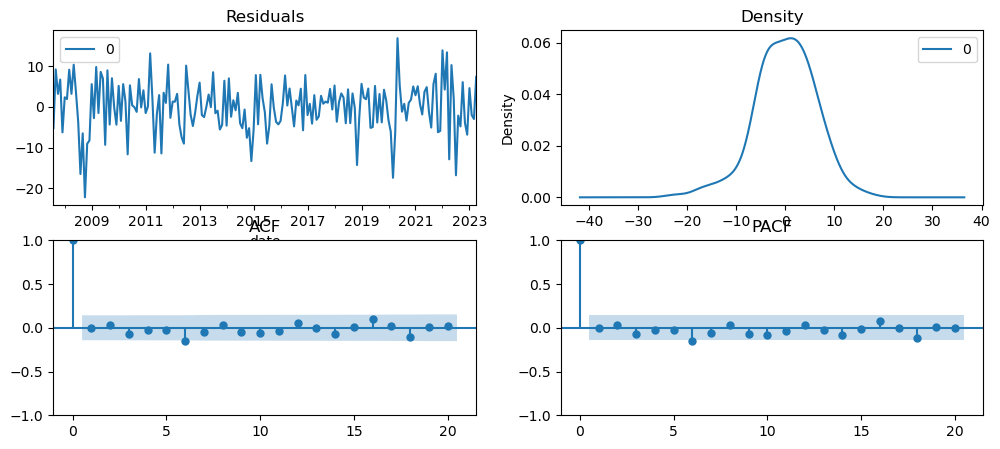

In [252]:
# Analizamos los residuos del modelo ARIMA
resid_arima_c = pd.DataFrame(results_ARIMA_c.resid)

n_rows = 2; n_cols = 2; figsize = (12,5)
fig, axes = plt.subplots(n_rows, n_cols,figsize=figsize)
resid = 'Residuals'; kde = 'kde'; density = 'Density'
ax00 = axes[0,0]; ax01 = axes[0,1]; ax10 = axes[1,0]; ax11 = axes[1,1]

resid_arima_c.plot(title=resid, ax=ax00);
resid_arima_c.plot(kind=kde, title=density, ax=ax01)
smt.graphics.plot_acf(resid_arima_c, lags=lags,ax=ax10,title=acf_t);
smt.graphics.plot_pacf(resid_arima_c, lags=lags,ax=ax11,title=pacf_t);

In [257]:
# Predecimos
len_test_close_c = len(df_test_c['close'])
alpha = 0.05
pred_ARIMA_c = results_ARIMA_c.forecast(len_test_close_c, alpha=alpha)

In [258]:
# Agregamos el output del modelo ARIMA a los datos originales
df_train_c['model_ARIMA'] = df_train_c['close'] + results_ARIMA_c.fittedvalues
df_test_c['model_ARIMA'] = df_test_c['close'] + pred_ARIMA_c
wti_ARIMA = df_test_c['model_ARIMA']

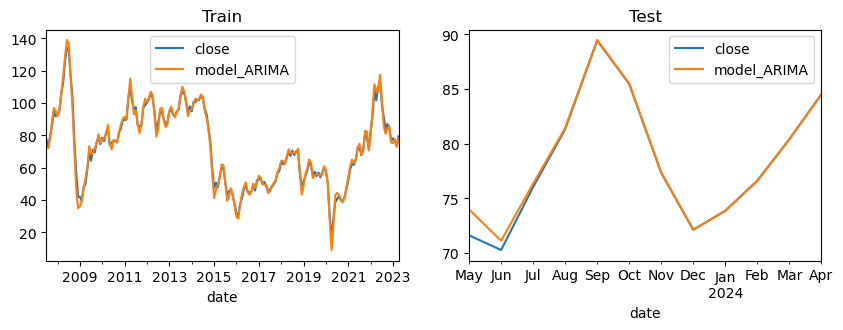

In [259]:
# Graficamos
fig, axes = plt.subplots(n_rows, n_cols,figsize=figsize)
y_arima_c = ['close', 'model_ARIMA']
n_rows = 1; n_cols = 2; figsize = (10,3); ax0 = axes[0]; ax1 = axes[1] ;
df_train_c.plot(kind='line', y=y_arima_c, ax=ax0, title=title_train);
df_test_c.plot(kind='line', y=y_arima_c, ax=ax1, title=title_test);

In [260]:
# Evaluamos la performance
crude_ARIMA_rmse = mean_squared_error(df_test_c['close'], df_test_c['model_ARIMA'], squared=root)
performance_df_c.loc[2] = ['ARIMA', crude_ARIMA_rmse]
performance_df_c

modelo       RMSE
0           Tendencia con Transformación Logarítmica  23.877551
1  Transformación Logarítmica + Estacionalidad Me...  23.833538
2                                              ARIMA   0.730366

## 6.5 SARIMAX

In [261]:
# Instanciamos el modelo SARIMAX con p y q igual a 1 y d igual a 0
model_SARIMAX_c = sm.tsa.statespace.SARIMAX(cf_c, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
results_SARIMAX_c = model_SARIMAX_c.fit()

In [262]:
results_SARIMAX_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         close_diff   No. Observations:                  189
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -588.844
Date:                            Thu, 23 May 2024   AIC                           1187.688
Time:                                    15:00:28   BIC                           1203.569
Sample:                                08-01-2007   HQIC                          1194.129
                                     - 04-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3782      0.156      2.417      0.016       0.072       0.685
ma.L1         -0.0019      0.190     -0.010      0.992      -0.374       0.371
ar.S.L12       0.0916      0.094      0.975      0.329      -0.093       0.276
ma.S.L12      -0.9995     16.011     -0.062      0.950     -32.381      30.382
sigma2        38.0923    607.581      0.063      0.950   -1152.745    1228.930
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.66
Prob(Q):                              0.96   Prob(JB):                         0.02
Heteroskedasticity (H):               0.93   Skew:                            -0.25
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

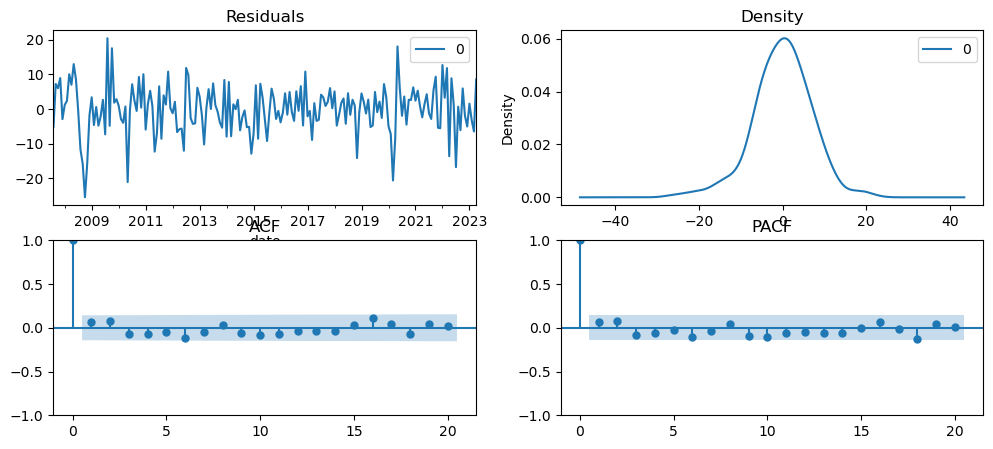

In [263]:
# Analizamos los residuos del modelo SARIMAX
resid_sarimax_c = pd.DataFrame(results_SARIMAX_c.resid)

n_rows = 2; n_cols = 2; figsize = (12,5)
fig, axes = plt.subplots(n_rows, n_cols,figsize=figsize)
ax00 = axes[0,0]; ax01 = axes[0,1]; ax10 = axes[1,0]; ax11 = axes[1,1]

resid_sarimax_c.plot(title=resid, ax=ax00);
resid_sarimax_c.plot(kind=kde, title=density, ax=ax01)
smt.graphics.plot_acf(resid_sarimax_c, lags=lags,ax=ax10,title=acf_t);
smt.graphics.plot_pacf(resid_sarimax_c, lags=lags,ax=ax11,title=pacf_t);

In [267]:
# Predecimos
pred_SARIMAX_c = results_SARIMAX_c.forecast(len_test_close_c, alpha=alpha)

In [268]:
# Agregamos el output del modelo SARIMAX a los datos originales
df_train_c['model_SARIMAX'] = df_train_c['close'] + results_SARIMAX_c.fittedvalues
df_test_c['model_SARIMAX'] = df_test_c['close'] + pred_SARIMAX_c

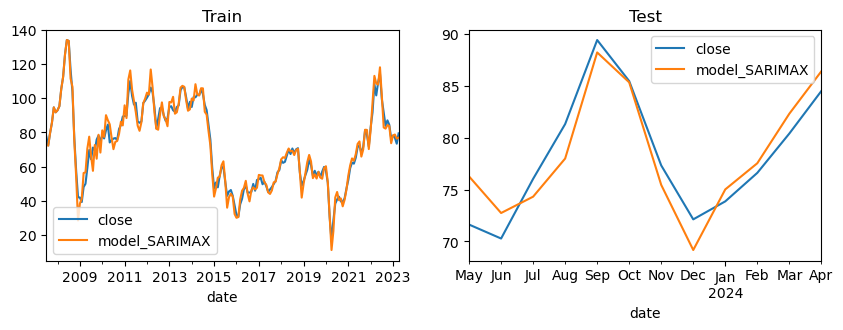

In [269]:
# Graficamos
fig, axes = plt.subplots(n_rows, n_cols,figsize=figsize)
y_sarimax_c = ['close', 'model_SARIMAX']
n_rows = 1; n_cols = 2; figsize = (10,3); ax0 = axes[0]; ax1 = axes[1];
df_train_c.plot(kind='line', y=y_sarimax_c, ax=ax0, title=title_train);
df_test_c.plot(kind='line', y=y_sarimax_c, ax=ax1, title=title_test);

In [270]:
# Evaluamos la performance
crude_SARIMAX_rmse = mean_squared_error(df_test_c['close'], df_test_c['model_SARIMAX'], squared=root)
performance_df_c.loc[3] = ['SARIMAX', crude_SARIMAX_rmse]
performance_df_c

modelo       RMSE
0           Tendencia con Transformación Logarítmica  23.877551
1  Transformación Logarítmica + Estacionalidad Me...  23.833538
2                                              ARIMA   0.730366
3                                            SARIMAX   2.325553

## 6.7. Evaluación de los modelos

In [271]:
# Armamos un df que unifique todos los resultados
performance_final = pd.concat([data_resultados, performance_df_c], axis=0)
performance_final

modelo       RMSE
0                    Reg Lineal Simple con timeIndex  21.893879
1                Reg Múltiple con timeIndex y volume   7.308234
2                      timeIndex elevado al cuadrado   8.476161
3                 Producto entre timeIndex y volume    7.454107
4                          Incluyendo estacionalidad   7.699968
0           Tendencia con Transformación Logarítmica  23.877551
1  Transformación Logarítmica + Estacionalidad Me...  23.833538
2                                              ARIMA   0.730366
3                                            SARIMAX   2.325553

# 7. Análisis de `Brent Oil`

## 7.1 Regresión Lineal Múltiple

In [272]:
# Nos quedamos con los datos para Brent Crude Oil
brent = df['commodity'] == 'Brent Crude Oil'
data_brent_crude = df[brent]
data_brent_crude.ticker.unique()


array(['BZ=F'], dtype=object)

In [273]:
data_brent_crude = data_brent_crude.reset_index(drop=True)
data_brent_crude

ticker        commodity       open       high        low      close  \
0      BZ=F  Brent Crude Oil  75.849998  76.529999  75.440002  75.739998   
1      BZ=F  Brent Crude Oil  75.699997  77.169998  75.669998  77.050003   
2      BZ=F  Brent Crude Oil  77.000000  77.059998  74.860001  75.349998   
3      BZ=F  Brent Crude Oil  75.220001  76.209999  74.269997  75.760002   
4      BZ=F  Brent Crude Oil  75.389999  76.000000  74.529999  74.750000   
...     ...              ...        ...        ...        ...        ...   
4153   BZ=F  Brent Crude Oil  87.230003  88.489998  86.040001  88.419998   
4154   BZ=F  Brent Crude Oil  88.459999  88.800003  87.650002  88.019997   
4155   BZ=F  Brent Crude Oil  88.110001  89.260002  87.290001  89.010002   
4156   BZ=F  Brent Crude Oil  89.209999  89.830002  88.800003  89.500000   
4157   BZ=F  Brent Crude Oil  88.320000  88.440002  88.320000  88.440002   

      volume       date  
0       2575 2007-07-30  
1       3513 2007-07-31  
2       3930 2007-08-01  
3       6180 2007-08-02  
4       4387 2007-08-03  
...      ...        ...  
4153   35381 2024-04-23  
4154   26662 2024-04-24  
4155   24588 2024-04-25  
4156   15475 2024-04-26  
4157     107 2024-04-29  

[4158 rows x 8 columns]

In [274]:
data_brent_oil = data_brent_crude.drop(['open', 'high', 'low', 'commodity', 'ticker'], axis=1)
data_brent_oil.head(3)

close  volume       date
0  75.739998    2575 2007-07-30
1  77.050003    3513 2007-07-31
2  75.349998    3930 2007-08-01

In [275]:
# Agrupamos por mes y sumamos
data_brent_gb = data_brent_oil.groupby('date')[['close', 'volume']].sum()
data_brent_gb = data_brent_gb.reset_index()
data_brent_gb = data_brent_gb.set_index('date')
data_brent_gb = data_brent_gb[['close','volume']].resample('MS').mean()
data_brent_gb.head(7)

close       volume
date                              
2007-07-01  76.395000  3044.000000
2007-08-01  71.258696  4436.173913
2007-09-01  77.135263  3265.368421
2007-10-01  82.456957  3216.260870
2007-11-01  92.060953  1937.190476
2007-12-01  91.394000  1446.600000
2008-01-01  92.112381  1520.142857

In [276]:
# Creamos una dummy de tiempo
brent_arange = np.arange(len(data_brent_gb['close']))
brent_index = data_brent_gb.index
data_brent_gb["timeIndex"] = pd.Series(brent_arange, index=brent_index)
data_brent_gb.tail(3)

close        volume  timeIndex
date                                          
2024-02-01  81.623999  26357.750000        199
2024-03-01  84.665499  27509.850000        200
2024-04-01  89.056190  34810.619048        201

Regresión lineal solo con las variables `close` y `timeIndex`

In [277]:
# Separamos el dataset en train y test
train_r, test_r = train_test_split(data_brent_gb,
                                  test_size=12,
                                  random_state=7,
                                  shuffle=False)

In [278]:
# Ajustamos el modelo lineal
model_linear = smf.ols(formula='close ~ timeIndex', data = train_r).fit()
# Generamos las predicciones para train y test
train_pred = train_r.copy()
test_pred = test_r.copy()
train_pred["LinearTrend"] = model_linear.predict(train_r.timeIndex)
test_pred["LinearTrend"] = model_linear.predict(test_r.timeIndex)

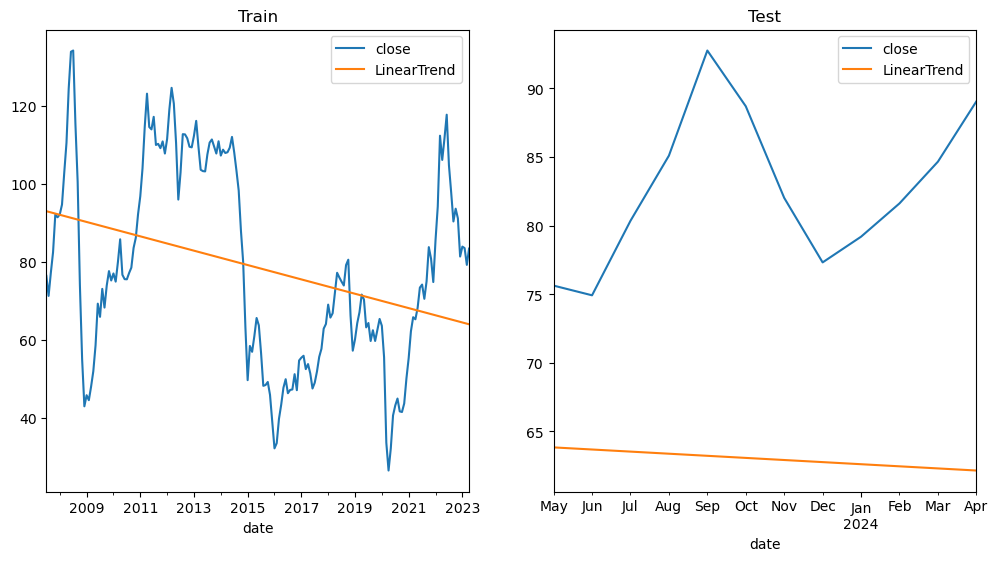

In [281]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","LinearTrend"],ax=axes[0],title='Train');
test_pred.plot(kind = "line", y = ["close","LinearTrend"],ax=axes[1],title='Test');
plt.show()

In [282]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     23.19
Date:                Thu, 23 May 2024   Prob (F-statistic):           3.01e-06
Time:                        15:01:19   Log-Likelihood:                -872.86
No. Observations:                 190   AIC:                             1750.
Df Residuals:                     188   BIC:                             1756.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     92.9516      3.477     26.737      0.000      86.094      99.810
timeIndex     -0.1532      0.032     -4.815      0.000      -0.216      -0.090
==============================================================================
Omnibus:                       45.156   Durbin-Watson:                   0.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.237
Skew:                           0.058   Prob(JB):                      0.00987
Kurtosis:                       1.926   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [283]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
brent_resultados = pd.DataFrame(columns = ["Model", "RMSE"])
brent_resultados.loc[0, "Model"] = "Reg Lineal Simple con timeIndex"
brent_resultados.loc[0, "RMSE"] = mean_squared_error(test_r.close, test_pred.LinearTrend, squared=False)
brent_resultados

Model       RMSE
0  Reg Lineal Simple con timeIndex  20.396584

Regresión lineal con  `close` como variable target y `timeIndex` y `volume` como variables predictoras

In [284]:
# Ajustamos el modelo lineal
model_linear = smf.ols(formula='close ~ timeIndex + volume', data = train_r).fit()
# Generamos las predicciones para train y test
train_pred["MultReg1"] = model_linear.predict(train_r[['timeIndex','volume']])
test_pred["MultReg1"] = model_linear.predict(test_r[['timeIndex','volume']])

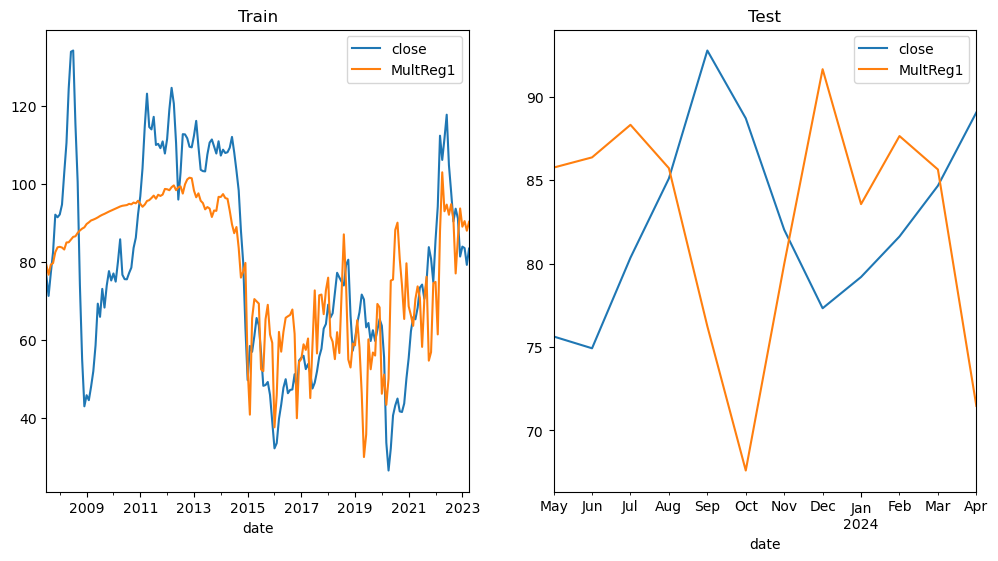

In [285]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","MultReg1"],ax=axes[0],title='Train');
test_pred.plot(kind = "line", y = ["close","MultReg1"],ax=axes[1],title='Test');
plt.show()

In [286]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     81.40
Date:                Thu, 23 May 2024   Prob (F-statistic):           3.72e-26
Time:                        15:01:22   Log-Likelihood:                -824.41
No. Observations:                 190   AIC:                             1655.
Df Residuals:                     187   BIC:                             1665.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     85.1851      2.790     30.537      0.000      79.682      90.688
timeIndex      0.2743      0.046      6.013      0.000       0.184       0.364
volume        -0.0020      0.000    -11.153      0.000      -0.002      -0.002
==============================================================================
Omnibus:                        3.042   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.858
Skew:                          -0.300   Prob(JB):                        0.240
Kurtosis:                       3.020   Cond. No.                     4.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [287]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
brent_resultados.loc[1, "Model"] = "RL Múltiple con timeIndex y volume"
brent_resultados.loc[1, "RMSE"] = mean_squared_error(test_r.close, test_pred['MultReg1'], squared=False)
brent_resultados

Model       RMSE
0     Reg Lineal Simple con timeIndex  20.396584
1  RL Múltiple con timeIndex y volume  11.510483

Regresión lineal con  `close` como variable target y `timeIndex` y `timeIndex` elevado al cuadrado como variables predictoras

In [288]:
# Creamos la variable predictora nueva
data_brent_gb['timeIndex_sq'] = data_brent_gb['timeIndex']**2
data_brent_gb['timeIndex_sq']

date
2007-07-01        0
2007-08-01        1
2007-09-01        4
2007-10-01        9
2007-11-01       16
              ...  
2023-12-01    38809
2024-01-01    39204
2024-02-01    39601
2024-03-01    40000
2024-04-01    40401
Freq: MS, Name: timeIndex_sq, Length: 202, dtype: int32

In [289]:
# Separamos el dataset en train y test
train_r, test_r = train_test_split(data_brent_gb,
                                  test_size=12,
                                  random_state=7,
                                  shuffle=False)

In [290]:
# Ajustamos el modelo lineal
model_quad = smf.ols(formula='close ~ timeIndex + timeIndex_sq', data = train_r).fit()
# Generamos las predicciones para train y test
train_pred = train_r.copy()
test_pred = test_r.copy()
train_pred["QuadraticTrend"] = model_quad.predict(train_r[['timeIndex','timeIndex_sq']])
test_pred["QuadraticTrend"] = model_quad.predict(test_r[['timeIndex','timeIndex_sq']])

<Axes: title={'center': 'Test'}, xlabel='date'>

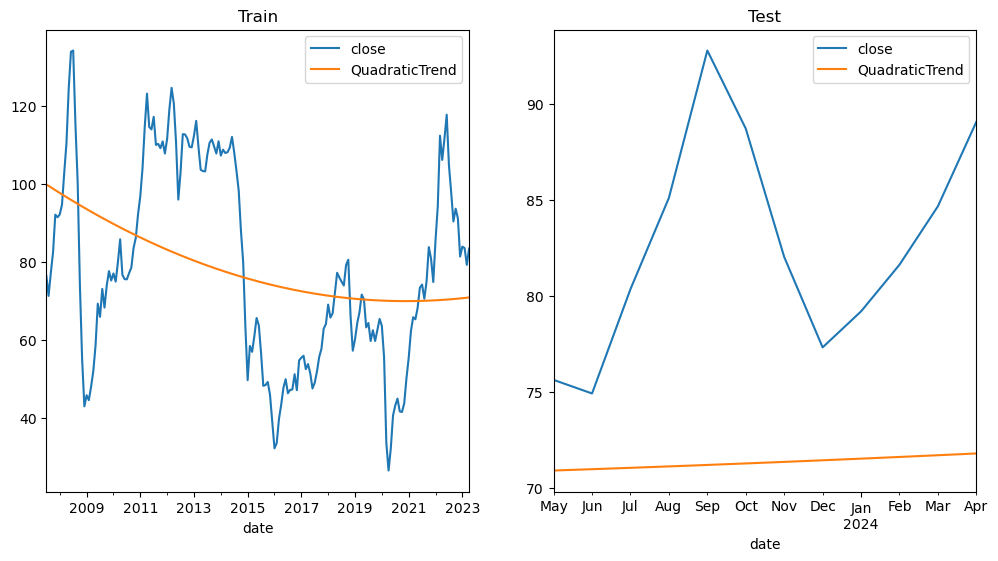

In [291]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","QuadraticTrend"],ax=axes[0],title='Train')
test_pred.plot(kind = "line", y = ["close","QuadraticTrend"],ax=axes[1],title='Test')

In [292]:
model_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     13.34
Date:                Thu, 23 May 2024   Prob (F-statistic):           3.83e-06
Time:                        15:01:27   Log-Likelihood:                -871.23
No. Observations:                 190   AIC:                             1748.
Df Residuals:                     187   BIC:                             1758.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       99.8089      5.150     19.379      0.000      89.649     109.969
timeIndex       -0.3721      0.126     -2.955      0.004      -0.620      -0.124
timeIndex_sq     0.0012      0.001      1.796      0.074      -0.000       0.002
==============================================================================
Omnibus:                       40.863   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.882
Skew:                           0.059   Prob(JB):                       0.0118
Kurtosis:                       1.947   Cond. No.                     4.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [293]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
brent_resultados.loc[2, "Model"] = "RL Múltiple con timeIndex^2"
brent_resultados.loc[2, "RMSE"] = mean_squared_error(test_r.close, test_pred["QuadraticTrend"], squared=False)
brent_resultados


Model       RMSE
0     Reg Lineal Simple con timeIndex  20.396584
1  RL Múltiple con timeIndex y volume  11.510483
2         RL Múltiple con timeIndex^2  12.449078

Regresión lineal con  `close` como variable target y `timeIndex`, `volume` y `time_volume` como variables predictoras

In [294]:
# Creamos la variable predictora nueva
data_brent_gb['time_volume'] = data_brent_gb['timeIndex']*data_brent_gb['volume']
data_brent_gb['time_volume']

date
2007-07-01    0.000000e+00
2007-08-01    4.436174e+03
2007-09-01    6.530737e+03
2007-10-01    9.648783e+03
2007-11-01    7.748762e+03
                  ...     
2023-12-01    4.738904e+06
2024-01-01    5.599770e+06
2024-02-01    5.245192e+06
2024-03-01    5.501970e+06
2024-04-01    6.996934e+06
Freq: MS, Name: time_volume, Length: 202, dtype: float64

In [295]:
# Separamos el dataset en train y test
train_r, test_r = train_test_split(data_brent_gb,
                                  test_size=12,
                                  random_state=7,
                                  shuffle=False)

In [296]:
# Ajustamos el modelo lineal
model_prod = smf.ols(formula='close ~ timeIndex + volume + time_volume', data = train_r).fit()
# Generamos las predicciones para train y test
train_pred = train_r.copy()
test_pred = test_r.copy()
train_pred["ProductTrend"] = model_prod.predict(train_r[['timeIndex','volume','time_volume']])
test_pred["ProductTrend"] = model_prod.predict(test_r[['timeIndex','volume','time_volume']])

<Axes: title={'center': 'Test'}, xlabel='date'>

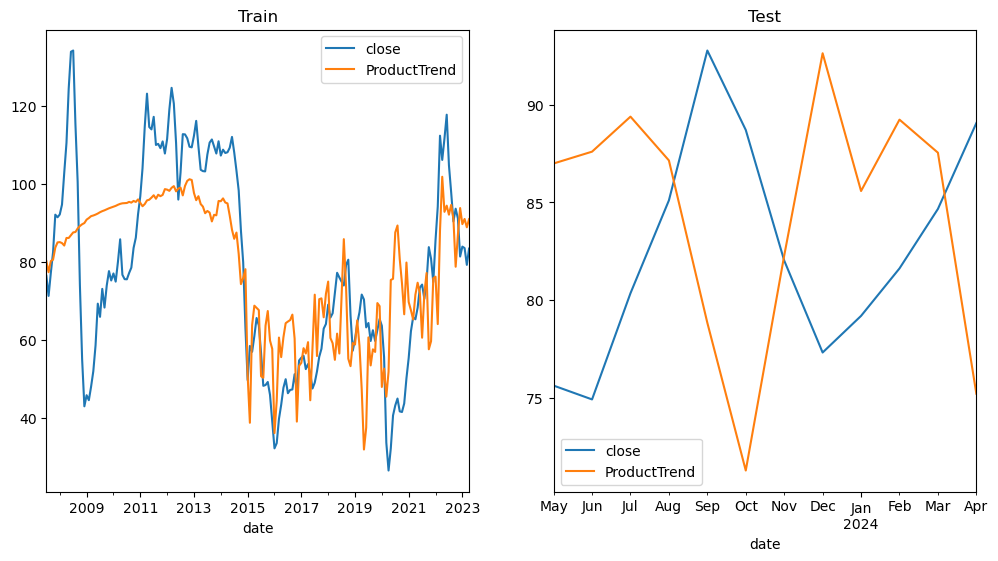

In [297]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","ProductTrend"],ax=axes[0],title='Train')
test_pred.plot(kind = "line", y = ["close","ProductTrend"],ax=axes[1],title='Test')

In [298]:
model_prod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     54.37
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.79e-25
Time:                        15:01:31   Log-Likelihood:                -824.09
No. Observations:                 190   AIC:                             1656.
Df Residuals:                     186   BIC:                             1669.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      86.9509      3.571     24.351      0.000      79.907      93.995
timeIndex       0.2413      0.062      3.909      0.000       0.120       0.363
volume         -0.0022      0.000     -6.188      0.000      -0.003      -0.002
time_volume  2.465e-06   3.11e-06      0.793      0.429   -3.66e-06    8.59e-06
==============================================================================
Omnibus:                        4.412   Durbin-Watson:                   0.269
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                4.261
Skew:                          -0.367   Prob(JB):                        0.119
Kurtosis:                       3.019   Cond. No.                     8.06e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El p-value de la interacción es mayor a 0.05

In [299]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
brent_resultados.loc[3, "Model"] = "RL Múltiple con producto entre timeIndex y volume "
brent_resultados.loc[3, "RMSE"] = mean_squared_error(test_r.close, test_pred["ProductTrend"], squared=False)
brent_resultados

Model       RMSE
0                    Reg Lineal Simple con timeIndex  20.396584
1                 RL Múltiple con timeIndex y volume  11.510483
2                        RL Múltiple con timeIndex^2  12.449078
3  RL Múltiple con producto entre timeIndex y vol...  10.820649

Regresión múltiple con estacionalidad

In [300]:
# Creamos columna month
train_r['month'] = [d.strftime('%b') for d in train_r.index]
test_r['month'] = [d.strftime('%b') for d in test_r.index]

In [301]:
# Creamos dummies y devolvemos DataFrames completos
train_r = pd.get_dummies(train_r, columns=['month'], prefix='', prefix_sep='', dtype='int')
test_r = pd.get_dummies(test_r, columns=['month'], prefix='', prefix_sep='', dtype='int')

In [302]:
test_r.columns

Index(['close', 'volume', 'timeIndex', 'timeIndex_sq', 'time_volume', 'Apr',
       'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Sep'],
      dtype='object')

In [303]:
# Generamos un modelo con estacionalidad
variables_y_x = 'close ~ timeIndex + volume + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep'
variables_x = ["timeIndex" ,"volume", "Apr", "Aug", "Dec", "Feb", "Jan", "Jul", "Jun", "Mar", "May", "Nov", "Oct" , "Sep"]
model_est = smf.ols(formula=variables_y_x, data = train_r).fit()
# Generamos las predicciones para train y test
train_pred = train_r.copy()
test_pred = test_r.copy()
train_pred["TrendSeason"] = model_est.predict(train_r[variables_x])
test_pred["TrendSeason"] = model_est.predict(test_r[variables_x])

<Axes: title={'center': 'Test'}, xlabel='date'>

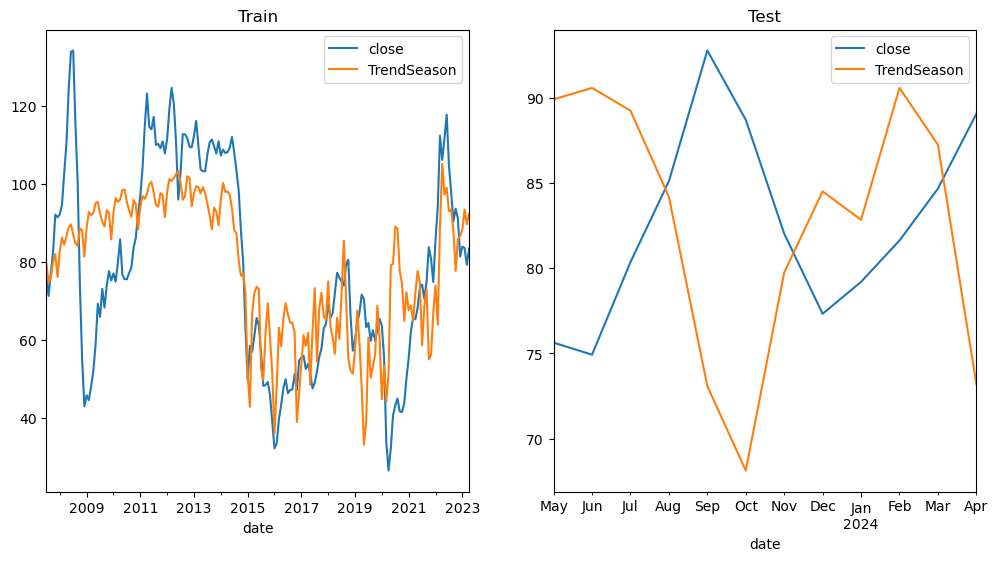

In [304]:
# Realizamos las gráficas
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train_pred.plot(kind = "line", y = ["close","TrendSeason"],ax=axes[0],title='Train')
test_pred.plot(kind = "line", y = ["close","TrendSeason"],ax=axes[1],title='Test')

In [305]:
model_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     12.50
Date:                Thu, 23 May 2024   Prob (F-statistic):           4.04e-19
Time:                        15:01:37   Log-Likelihood:                -821.78
No. Observations:                 190   AIC:                             1672.
Df Residuals:                     176   BIC:                             1717.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.6187      2.620     30.008      0.000      73.448      83.789
timeIndex      0.2802      0.047      6.012      0.000       0.188       0.372
volume        -0.0020      0.000    -11.044      0.000      -0.002      -0.002
Apr            8.1747      4.563      1.792      0.075      -0.831      17.180
Aug            4.6980      4.558      1.031      0.304      -4.298      13.694
Dec           -1.0056      4.566     -0.220      0.826     -10.017       8.006
Feb            9.1208      4.565      1.998      0.047       0.111      18.131
Jan            5.5310      4.560      1.213      0.227      -3.467      14.529
Jul            7.1185      4.556      1.563      0.120      -1.873      16.110
Jun           10.4329      4.693      2.223      0.027       1.170      19.696
Mar            7.8192      4.559      1.715      0.088      -1.179      16.817
May           10.3876      4.692      2.214      0.028       1.127      19.648
Nov            6.0902      4.556      1.337      0.183      -2.901      15.082
Oct            7.0400      4.554      1.546      0.124      -1.947      16.027
Sep            3.2113      4.564      0.704      0.483      -5.797      12.219
==============================================================================
Omnibus:                        5.476   Durbin-Watson:                   0.261
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                5.360
Skew:                          -0.411   Prob(JB):                       0.0685
Kurtosis:                       3.034   Cond. No.                     2.01e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.21e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [306]:
# Evaluamos el desempeño con RMSE y almacenamos los resultados
brent_resultados.loc[4, "Model"] = "RL Múltiple + estacionalidad"
brent_resultados.loc[4, "RMSE"] = mean_squared_error(test_r.close, test_pred["TrendSeason"], squared=False)
brent_resultados

Model       RMSE
0                    Reg Lineal Simple con timeIndex  20.396584
1                 RL Múltiple con timeIndex y volume  11.510483
2                        RL Múltiple con timeIndex^2  12.449078
3  RL Múltiple con producto entre timeIndex y vol...  10.820649
4                       RL Múltiple + estacionalidad  12.065263

Observación: El mejor resultado se obtuvo para la regresión múltiple con variables predictoras `timeIndex`y `volume`

## 7.2 Tendencia con Transformación Logarítimica y con Transformación Logarítimica + Estacionalidad Mensual

In [307]:
brent = df['commodity'] == 'Brent Crude Oil'
brent_crude = df[brent]
brent_crude.ticker.unique()

array(['BZ=F'], dtype=object)

In [308]:
# elimino el index
brent_crude = brent_crude.reset_index(drop=True)
brent_crude

ticker        commodity       open       high        low      close  \
0      BZ=F  Brent Crude Oil  75.849998  76.529999  75.440002  75.739998   
1      BZ=F  Brent Crude Oil  75.699997  77.169998  75.669998  77.050003   
2      BZ=F  Brent Crude Oil  77.000000  77.059998  74.860001  75.349998   
3      BZ=F  Brent Crude Oil  75.220001  76.209999  74.269997  75.760002   
4      BZ=F  Brent Crude Oil  75.389999  76.000000  74.529999  74.750000   
...     ...              ...        ...        ...        ...        ...   
4153   BZ=F  Brent Crude Oil  87.230003  88.489998  86.040001  88.419998   
4154   BZ=F  Brent Crude Oil  88.459999  88.800003  87.650002  88.019997   
4155   BZ=F  Brent Crude Oil  88.110001  89.260002  87.290001  89.010002   
4156   BZ=F  Brent Crude Oil  89.209999  89.830002  88.800003  89.500000   
4157   BZ=F  Brent Crude Oil  88.320000  88.440002  88.320000  88.440002   

      volume       date  
0       2575 2007-07-30  
1       3513 2007-07-31  
2       3930 2007-08-01  
3       6180 2007-08-02  
4       4387 2007-08-03  
...      ...        ...  
4153   35381 2024-04-23  
4154   26662 2024-04-24  
4155   24588 2024-04-25  
4156   15475 2024-04-26  
4157     107 2024-04-29  

[4158 rows x 8 columns]

In [309]:
# Pasamos de Series a DataFrame y luego agrupamos por mes
brent_gb = brent_crude.groupby('date')['close'].sum()
brent_gb = brent_gb.reset_index()
brent_gb = brent_gb.set_index('date')
y_brent = brent_gb['close'].resample('MS').mean().to_frame()

<Figure size 600x600 with 0 Axes>

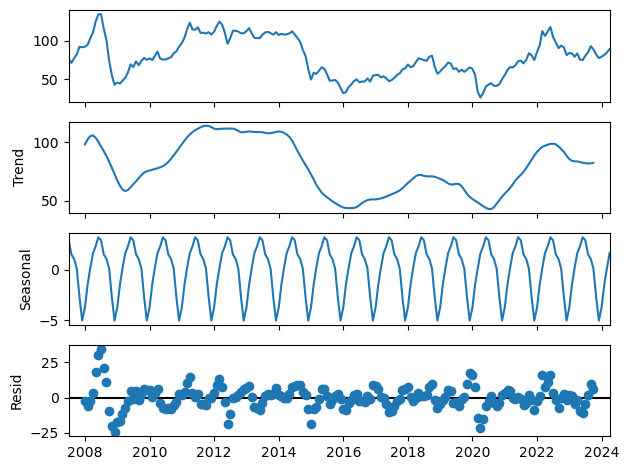

In [310]:
# Descomponemos la serie temporal en sus componentes de tendencia, estacionalidad y residuos
figsize = (6,6)
plt.figure(figsize=figsize)
decomposition_brent = sm.tsa.seasonal_decompose(y_brent, model=decomposition_model)
decomposition_brent.plot();

In [311]:
# Pasamos valores a comienzo de mes y utilizamos la media
brent_gb = brent_gb['close'].resample('MS').mean().to_frame()
brent_gb.head(3)

close
date                 
2007-07-01  76.395000
2007-08-01  71.258696
2007-09-01  77.135263

In [312]:
# df_brent["timeIndex"] = pd.Series(np.arange(len(df_brent["close"])), index=df_brent.index)
#df_brent.dtypes

# Creamos una dummy de tiempo
brent_arange = np.arange(len(brent_gb['close']))
brent_index = brent_gb.index
brent_gb["timeIndex"] = pd.Series(brent_arange, index=brent_index)
brent_gb.head(3)


close  timeIndex
date                            
2007-07-01  76.395000          0
2007-08-01  71.258696          1
2007-09-01  77.135263          2

In [313]:
# Dividimos el dataset en train y test y no mezclamos las observaciones
df_train_b, df_test_b = train_test_split(brent_gb, test_size=12, random_state=42, shuffle=False)

In [314]:
df_train_b.shape

(190, 2)

In [315]:
# Verificamos los últimos datos de df_train
df_train_b.tail(2)

close  timeIndex
date                            
2023-03-01  79.206956        188
2023-04-01  83.368948        189

In [316]:
# Verificamos los primeros datos de df_test
df_test_b.head(2)

close  timeIndex
date                            
2023-05-01  75.632274        190
2023-06-01  74.925714        191

In [317]:
# Creamos columna month
# en train
df_train_b['month'] = [d.strftime('%b') for d in df_train_b.index]
# en test
df_test_b['month']  = [d.strftime('%b') for d in df_test_b.index]


# Creamos dummies y devolvemos DataFrames completos
df_train_b = pd.get_dummies(df_train_b, columns=['month'], prefix='', prefix_sep='')
df_test_b = pd.get_dummies(df_test_b, columns=['month'], prefix='', prefix_sep='')

In [318]:
# Verificamos las columnas
df_train_b.head(3)

close  timeIndex    Apr    Aug    Dec    Feb    Jan    Jul  \
date                                                                         
2007-07-01  76.395000          0  False  False  False  False  False   True   
2007-08-01  71.258696          1  False   True  False  False  False  False   
2007-09-01  77.135263          2  False  False  False  False  False  False   

              Jun    Mar    May    Nov    Oct    Sep  
date                                                  
2007-07-01  False  False  False  False  False  False  
2007-08-01  False  False  False  False  False  False  
2007-09-01  False  False  False  False  False   True

In [319]:
df_test_b.head(3)

close  timeIndex    Apr    Aug    Dec    Feb    Jan    Jul  \
date                                                                         
2023-05-01  75.632274        190  False  False  False  False  False  False   
2023-06-01  74.925714        191  False  False  False  False  False  False   
2023-07-01  80.355500        192  False  False  False  False  False   True   

              Jun    Mar    May    Nov    Oct    Sep  
date                                                  
2023-05-01  False  False   True  False  False  False  
2023-06-01   True  False  False  False  False  False  
2023-07-01  False  False  False  False  False  False

In [320]:
# Hacemos una transformación logarítmica
df_train_b["log_close"] = np.log(df_train_b["close"])
df_test_b["log_close"] = np.log(df_test_b["close"])

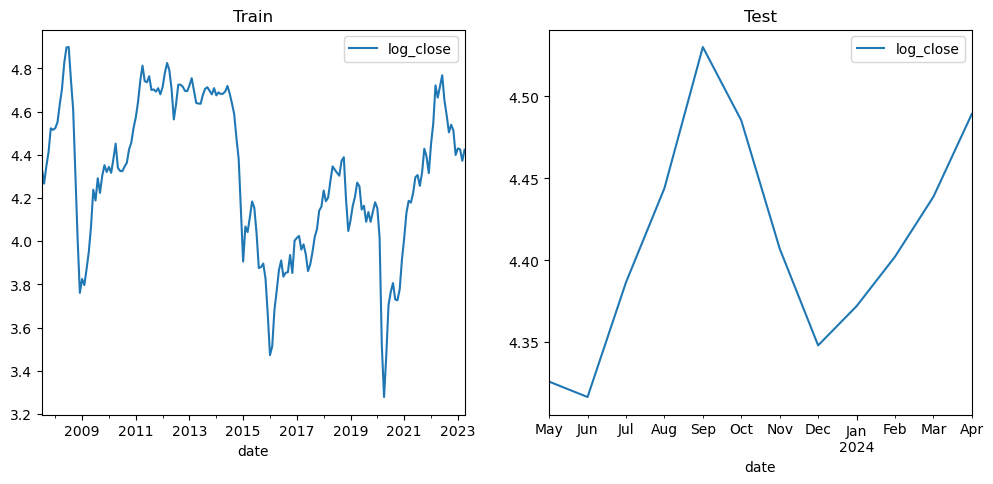

In [321]:
# Graficamos
n_rows = 1; n_cols = 2; figsize = (12,5)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
title_train = 'Train'; title_test = 'Test'; ax0 = axes[0]; ax1 = axes[1]; log_c = ['log_close']
df_train_b.plot(kind='line', y=log_c, ax=ax0, title=title_train);
df_test_b.plot(kind='line', y=log_c, ax=ax1, title=title_test);

In [322]:
meses = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
meses

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

In [323]:
# Generamos un modelo de regresión lineal usando el logaritmo del valor 'close' de Brent

variable_dependiente = 'log_close'
variables_independientes_sinEstacionalidad = ['timeIndex']
variables_independientes_conEstacionalidad = ['timeIndex'] + meses

formula = variable_dependiente + ' ~ ' + ' + '.join(variables_independientes_sinEstacionalidad)

model_log = smf.ols(formula, data=df_train_b).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_close   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     20.61
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.00e-05
Time:                        15:01:47   Log-Likelihood:                -57.708
No. Observations:                 190   AIC:                             119.4
Df Residuals:                     188   BIC:                             125.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4932      0.048     94.329      0.000       4.399       4.587
timeIndex     -0.0020      0.000     -4.540      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       10.283   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                8.339
Skew:                          -0.419   Prob(JB):                       0.0155
Kurtosis:                       2.408   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [324]:
# Predecimos

df_train_b["model_log"]=model_log.predict(df_train_b["timeIndex"])
df_test_b["model_log"]=model_log.predict(df_test_b["timeIndex"])

In [325]:
# Restauramos el valor predicho de close al aplicar la función exponencial

df_train_b["back_log_close"]=np.exp(df_train_b["model_log"])
df_test_b["back_log_close"]=np.exp(df_test_b["model_log"])

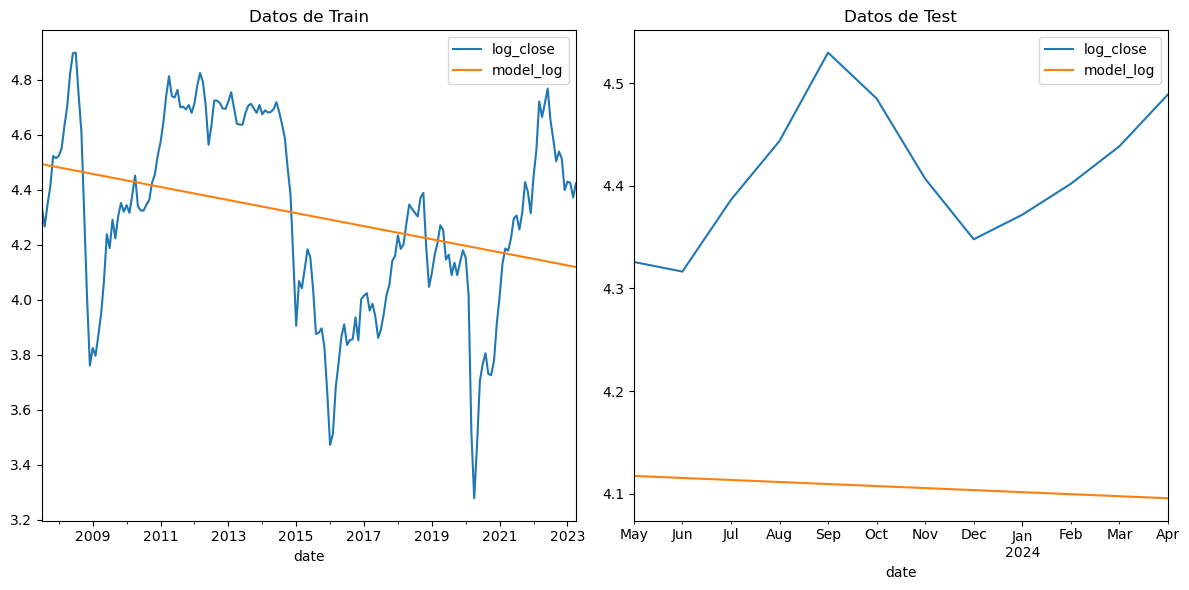

In [326]:
# Comparamos el valor de close con el valor real
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficar los datos de entrenamiento en el primer subplot
df_train_b.plot(kind="line",y=["log_close","model_log"], ax=axs[0])
axs[0].set_title("Datos de Train")

# Graficar los datos de prueba en el segundo subplot
df_test_b.plot(kind="line",y=["log_close","model_log"], ax=axs[1])
axs[1].set_title("Datos de Test")

# Ajustar los espacios entre los subplots
plt.tight_layout()

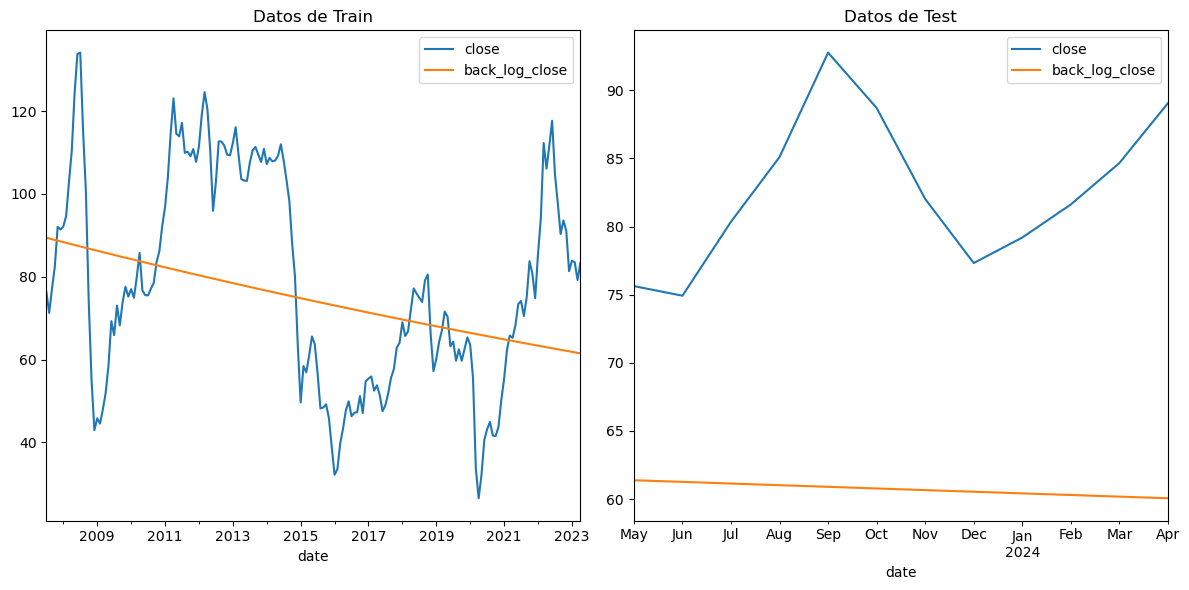

In [327]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficar los datos de entrenamiento en el primer subplot
df_train_b.plot(kind="line",y=["close","back_log_close"], ax=axs[0])
axs[0].set_title("Datos de Train")

# Graficar los datos de prueba en el segundo subplot
df_test_b.plot(kind="line",y=["close","back_log_close"], ax=axs[1])
axs[1].set_title("Datos de Test")

# Ajustar los espacios entre los subplots
plt.tight_layout()

In [328]:
# Calculamos la performance con el MSE y el RMSE

brent_mse_log = mean_squared_error(df_test_b.close,df_test_b.back_log_close)
print("El Mean Squared Error (MSE) es:", brent_mse_log)

brent_rmse_log = np.sqrt(brent_mse_log)
print("El Root Mean Squared Error (RMSE) es:", brent_rmse_log)

# guardamos el rmse en un diccionario
brent_dict = {'Model':['Tendencia con Transformación Logarítmica'], 'RMSE':[brent_rmse_log]}
performance_df_b = pd.DataFrame(brent_dict)


El Mean Squared Error (MSE) es: 509.93009436881266
El Root Mean Squared Error (RMSE) es: 22.581631791542716


#### Sumamos la estacionalidad

In [329]:
# Generamos un modelo incorporando la estacionalidad del valor 'close' de Brent

formula_est = variable_dependiente + ' ~ ' + ' + '.join(variables_independientes_conEstacionalidad)

model_log_est = smf.ols(formula_est, data=df_train_b).fit()

model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_close   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.736
Date:                Thu, 23 May 2024   Prob (F-statistic):             0.0627
Time:                        15:01:51   Log-Likelihood:                -57.021
No. Observations:                 190   AIC:                             140.0
Df Residuals:                     177   BIC:                             182.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.1473      0.045     91.768      0.000       4.058       4.237
Jan[T.True]     0.3009      0.081      3.707      0.000       0.141       0.461
Feb[T.True]     0.3315      0.081      4.084      0.000       0.171       0.492
Mar[T.True]     0.3408      0.081      4.197      0.000       0.181       0.501
Apr[T.True]     0.3600      0.081      4.431      0.000       0.200       0.520
May[T.True]     0.3718      0.084      4.449      0.000       0.207       0.537
Jun[T.True]     0.3923      0.084      4.693      0.000       0.227       0.557
Jul[T.True]     0.3721      0.081      4.590      0.000       0.212       0.532
Aug[T.True]     0.3530      0.081      4.353      0.000       0.193       0.513
Sep[T.True]     0.3517      0.081      4.337      0.000       0.192       0.512
Oct[T.True]     0.3538      0.081      4.363      0.000       0.194       0.514
Nov[T.True]     0.3276      0.081      4.039      0.000       0.168       0.488
Dec[T.True]     0.2917      0.081      3.596      0.000       0.132       0.452
timeIndex      -0.0020      0.000     -4.401      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       11.861   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                9.030
Skew:                          -0.427   Prob(JB):                       0.0109
Kurtosis:                       2.358   Cond. No.                     4.04e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.39e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [330]:
# Predecimos
df_train_b["model_log_est"]=model_log_est.predict(df_train_b[["timeIndex"]+meses])
df_test_b["model_log_est"]=model_log_est.predict(df_test_b[["timeIndex"]+meses])

In [331]:
# Restauramos el valor predicho de close al aplicar la función exponencial
df_train_b["back_log_close_est"]=np.exp(df_train_b["model_log_est"])
df_test_b["back_log_close_est"]=np.exp(df_test_b["model_log_est"])

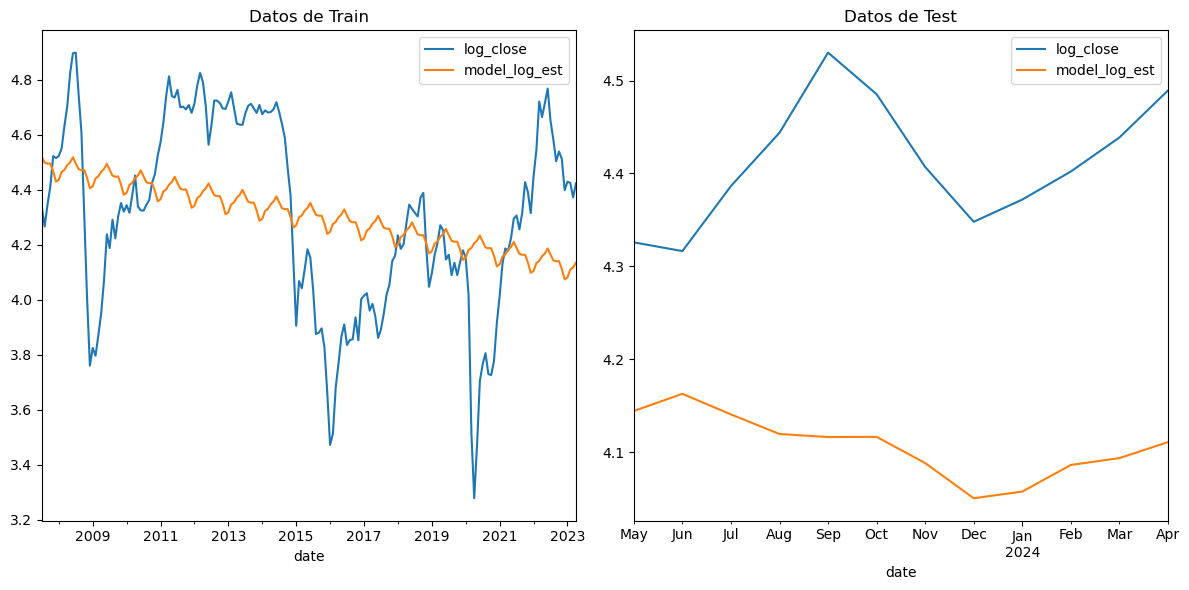

In [332]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficar los datos de entrenamiento en el primer subplot
df_train_b.plot(kind="line", y=["log_close", "model_log_est"], ax=axs[0])
axs[0].set_title("Datos de Train")

# Graficar los datos de prueba en el segundo subplot
df_test_b.plot(kind="line", y=["log_close", "model_log_est"], ax=axs[1])
axs[1].set_title("Datos de Test")

# Ajustar los espacios entre los subplots
plt.tight_layout()

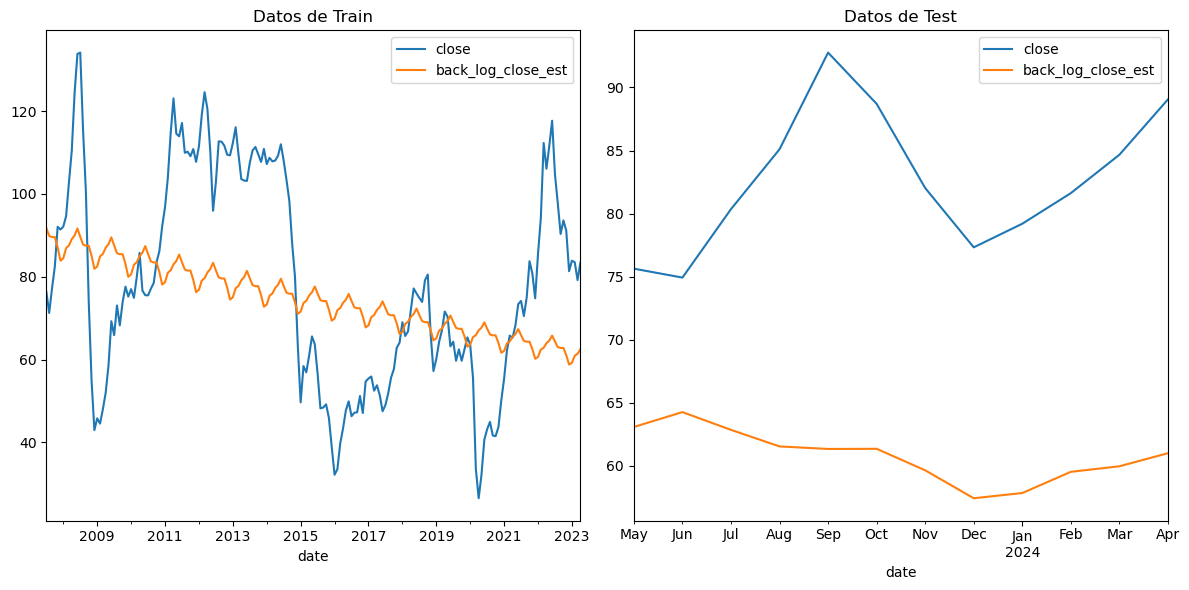

In [333]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficar los datos de entrenamiento en el primer subplot
df_train_b.plot(kind="line",y=["close","back_log_close_est"], ax=axs[0])
axs[0].set_title("Datos de Train")

# Graficar los datos de prueba en el segundo subplot
df_test_b.plot(kind="line",y=["close","back_log_close_est"], ax=axs[1])
axs[1].set_title("Datos de Test")

# Ajustar los espacios entre los subplots
plt.tight_layout()

In [334]:
# Calculamos la performance con el MSE y el RMSE
brent_mse_log_est = mean_squared_error(df_test_b.close,df_test_b.back_log_close_est)
print("El Mean Squared Error (MSE) es:", brent_mse_log_est)
brent_rmse_log_est = np.sqrt(brent_mse_log_est)
print("El Root Mean Squared Error (RMSE) es:", brent_rmse_log_est)
# guardamos el rmse
performance_df_b.loc[1] = ['Transformación Logarítmica + Estacionalidad Mensual', brent_rmse_log_est]
performance_df_b

El Mean Squared Error (MSE) es: 509.05991409005225
El Root Mean Squared Error (RMSE) es: 22.56235612896074


Model       RMSE
0           Tendencia con Transformación Logarítmica  22.581632
1  Transformación Logarítmica + Estacionalidad Me...  22.562356

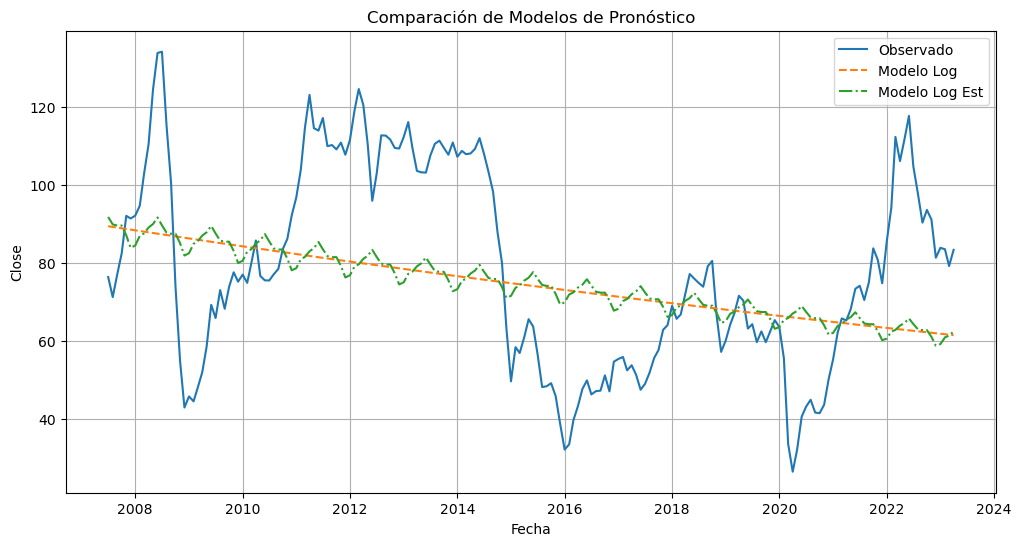

In [335]:
# Gráfico comparativo de modelos de pronóstico
plt.figure(figsize=(12, 6))
plt.plot(df_train_b.index, df_train_b['close'], label='Observado')
plt.plot(df_train_b.index, df_train_b['back_log_close'], label='Modelo Log', linestyle='--')
plt.plot(df_train_b.index, df_train_b['back_log_close_est'], label='Modelo Log Est', linestyle='-.')
plt.title('Comparación de Modelos de Pronóstico')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()


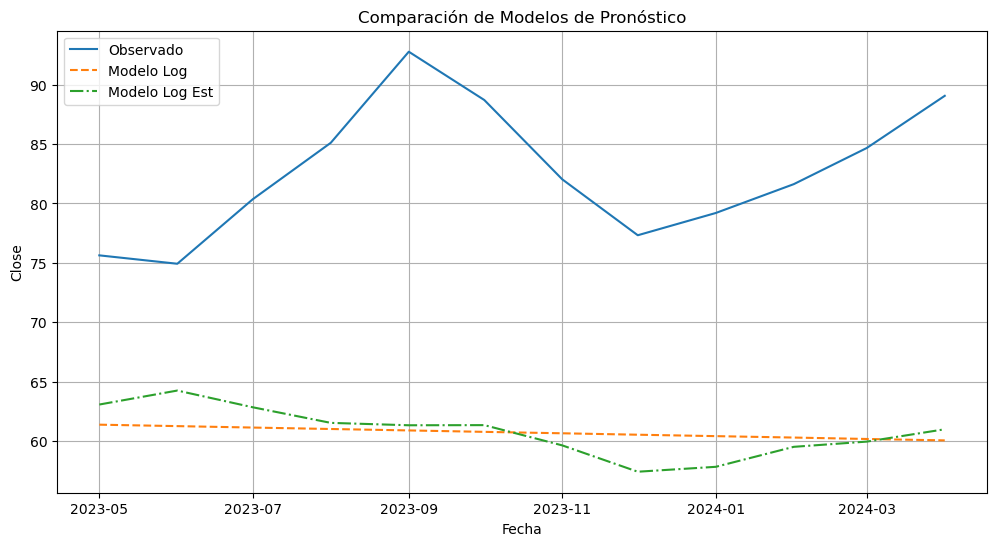

In [336]:
# Gráfico comparativo de modelos de pronóstico
plt.figure(figsize=(12, 6))
plt.plot(df_test_b.index, df_test_b['close'], label='Observado')
plt.plot(df_test_b.index, df_test_b['back_log_close'], label='Modelo Log', linestyle='--')
plt.plot(df_test_b.index, df_test_b['back_log_close_est'], label='Modelo Log Est', linestyle='-.')
plt.title('Comparación de Modelos de Pronóstico')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()


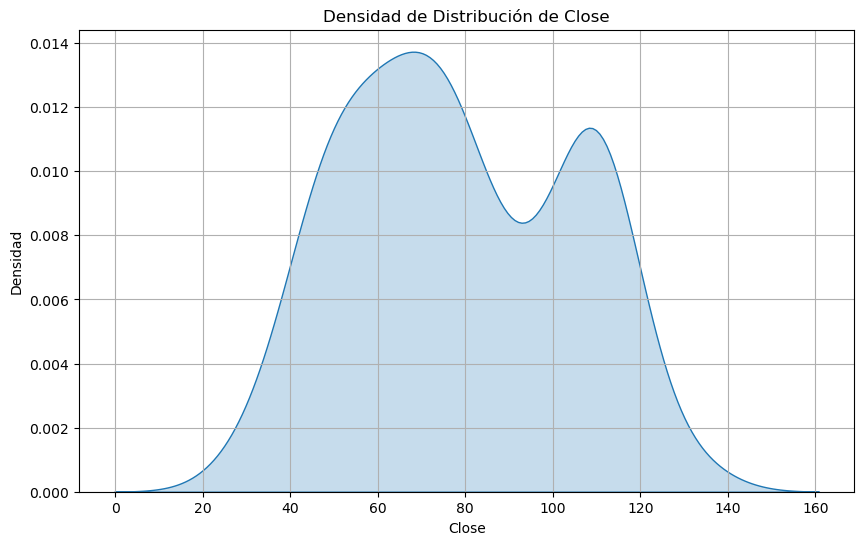

In [337]:
# Gráfico de densidad de distribución de close
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train_b['close'], shade=True)
plt.title('Densidad de Distribución de Close')
plt.xlabel('Close')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

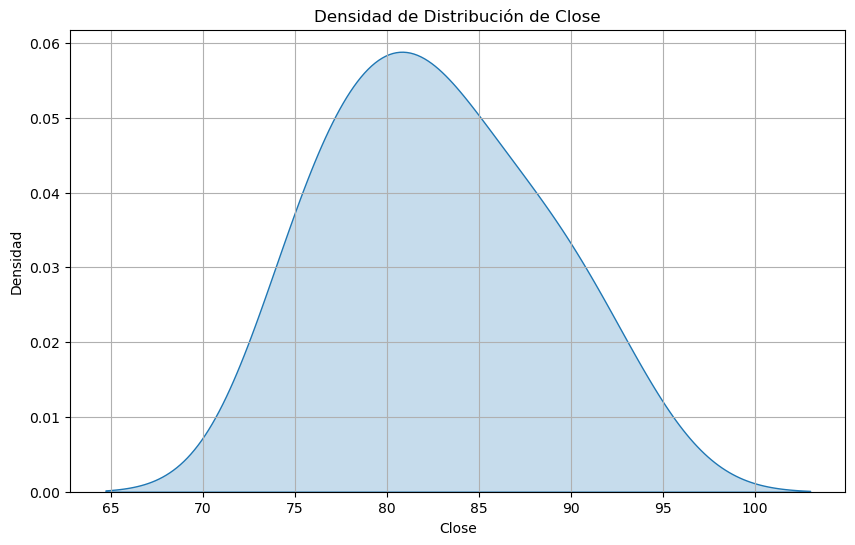

In [338]:
# Gráfico de densidad de distribución de Close
plt.figure(figsize=(10, 6))
sns.kdeplot(df_test_b['close'], shade=True)
plt.title('Densidad de Distribución de Close')
plt.xlabel('Close')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

## 7.3 ARIMA

Text(0.5, 1.0, 'Residuo')

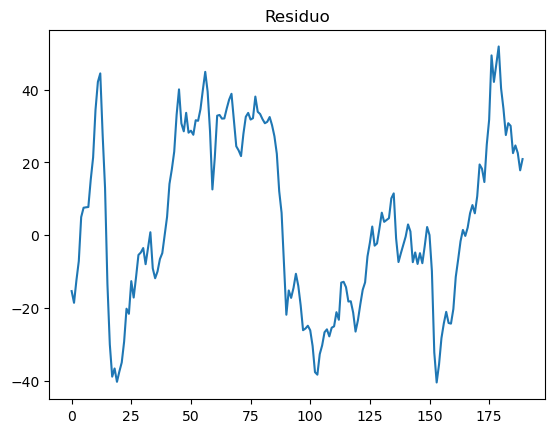

In [339]:
# calculamos los residuos del ultimo modelo
residuo = df_train_b["close"] - df_train_b["back_log_close_est"]
plt.plot(df_train_b.timeIndex,residuo,"-")
plt.title("Residuo")

In [340]:
# Aplicamos el test de Dickey-Fuller aumentado al residuo

result = adfuller(residuo)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.905055
p-value: 0.044763
	1%: -3.466
	5%: -2.877
	10%: -2.575


In [341]:
def tsplot(y, lags=None, title='Análisis de Serie de Tiempo'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=(12, 7))

    ts_ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    acf_ax = plt.subplot2grid((2, 2), (1, 0))
    pacf_ax = plt.subplot2grid((2, 2), (1, 1))

    y.plot(ax=ts_ax, title=title)

    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(f'{title}\nDickey-Fuller: p={p_value:.5f}')

    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)

    plt.tight_layout()


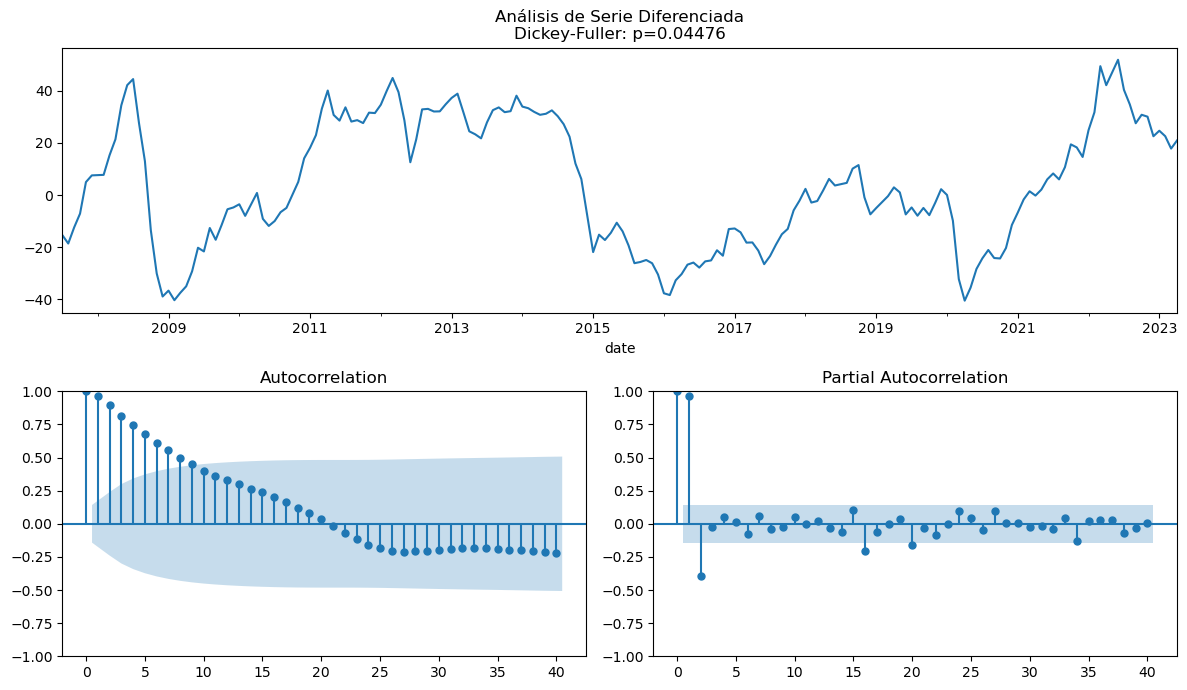

In [342]:
tsplot(residuo, lags=40, title='Análisis de Serie Diferenciada')

In [343]:
df_train_b['Diferenciada'] = df_train_b['close'].diff()

df_train_b_diff=df_train_b['Diferenciada'].dropna()

resultado_adf_diferenciada = adfuller(df_train_b_diff)

print('Estadístico ADF :', resultado_adf_diferenciada[0])
print('p-valor :', resultado_adf_diferenciada[1])
for key, value in resultado_adf_diferenciada[4].items():
    print('\t%s: %.3f' % (key, value))


Estadístico ADF : -8.783428345810488
p-valor : 2.3430800318312086e-14
	1%: -3.466
	5%: -2.877
	10%: -2.575


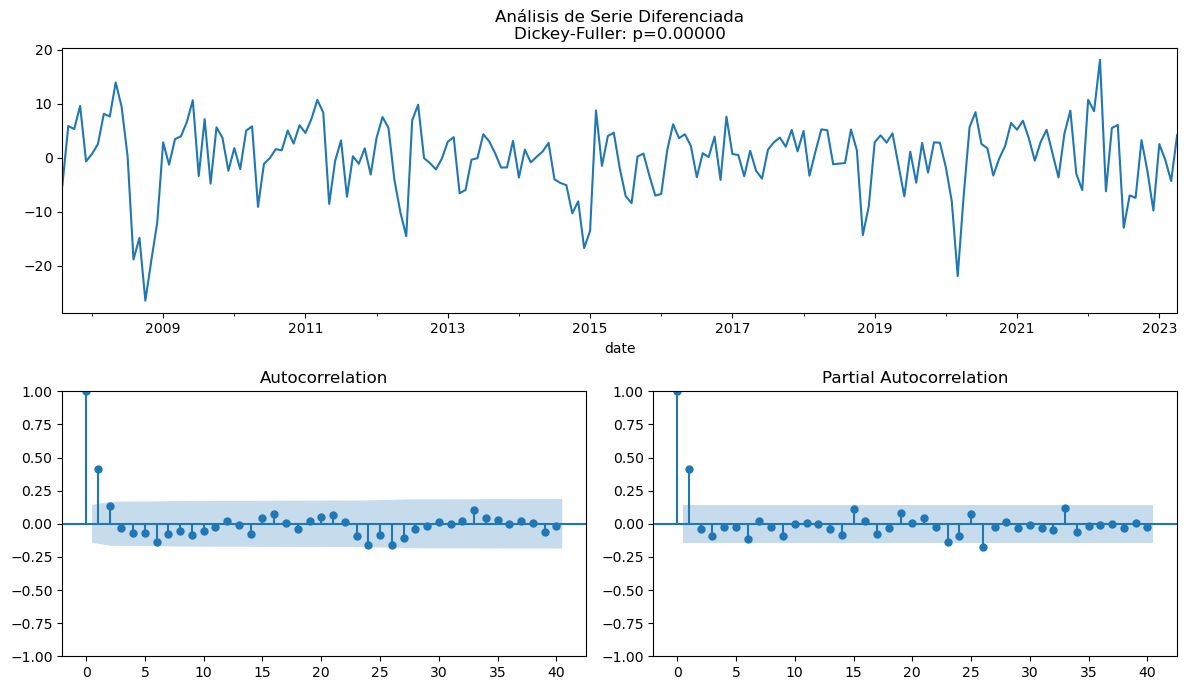

In [344]:
tsplot(df_train_b_diff, lags=40, title='Análisis de Serie Diferenciada')

In [345]:
# Instanciamos y fiteamos el modelo ARIMA utilizando valores de 1 para p y q y 1 para d, ya que la serie es no estacionaria

order = (1,1,1)
model_ARIMA = ARIMA(df_train_b_diff, order=order).fit()

print(model_ARIMA.summary())


                               SARIMAX Results                                
Dep. Variable:           Diferenciada   No. Observations:                  189
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -604.606
Date:                Thu, 23 May 2024   AIC                           1215.213
Time:                        15:02:04   BIC                           1224.922
Sample:                    08-01-2007   HQIC                          1219.147
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4209      0.058      7.287      0.000       0.308       0.534
ma.L1         -0.9996      0.853     -1.172      0.241      -2.671       0.672
sigma2        35.5633     30.567      1.163      0.2

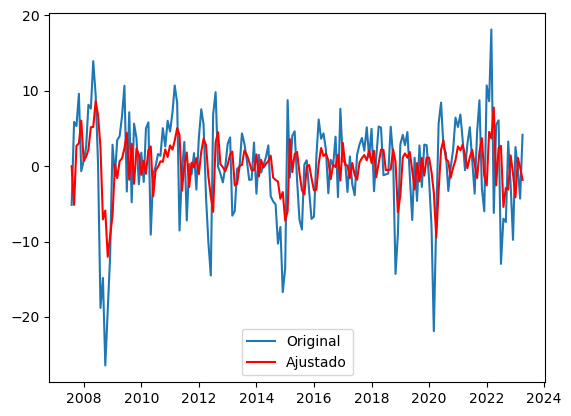

In [346]:
plt.plot(df_train_b_diff, label='Original')
plt.plot(model_ARIMA.fittedvalues, color='red', label='Ajustado')
plt.legend(loc='best')

In [347]:
# Predecimos
alpha = 0.05
predictions_ARIMA, se, conf, *_ = model_ARIMA.forecast(len(df_test_b['close']), alpha=alpha)

In [348]:
# Agregamos el output del modelo ARIMA a los datos originales
df_train_b['model_ARIMA'] = df_train_b['close']+ model_ARIMA.fittedvalues
df_test_b['model_ARIMA'] = df_test_b['close'] + predictions_ARIMA
brent_ARIMA = df_test_b['model_ARIMA']

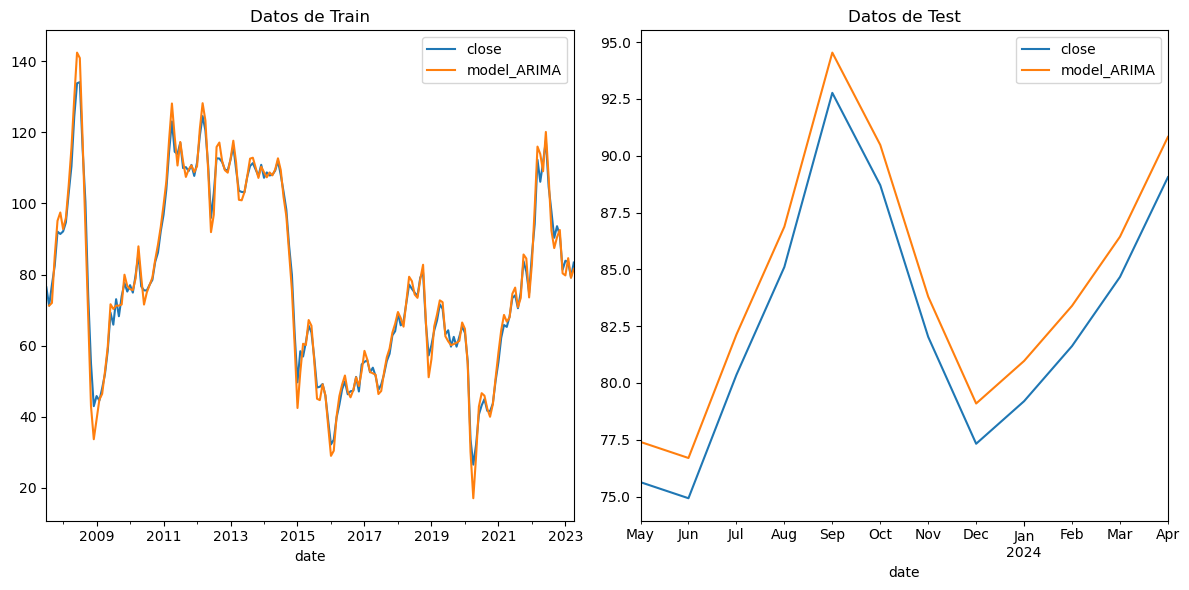

In [349]:
# Graficamos

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficar los datos de entrenamiento en el primer subplot
df_train_b.plot(kind = "line", y = ['close', 'model_ARIMA'], ax=axs[0])
axs[0].set_title("Datos de Train")

df_test_b.plot(kind = "line", y = ['close', 'model_ARIMA'], ax=axs[1])
axs[1].set_title("Datos de Test")

# Ajustar los espacios entre los subplots
plt.tight_layout()

In [350]:
# Evaluamos la performance

brent_mse_arima = mean_squared_error(df_test_b['close'], df_test_b['model_ARIMA'])
brent_rmse_arima = np.sqrt(brent_mse_arima)
print("El Mean Squared Error (MSE) es:",brent_mse_arima)
print("El Root Mean Squared Error (RMSE) es:",brent_rmse_arima)

# guardamos el rmse
performance_df_b.loc[2] = ['ARIMA', brent_rmse_arima]
performance_df_b

El Mean Squared Error (MSE) es: 3.1367796931717855
El Root Mean Squared Error (RMSE) es: 1.7710956194321597


Model       RMSE
0           Tendencia con Transformación Logarítmica  22.581632
1  Transformación Logarítmica + Estacionalidad Me...  22.562356
2                                              ARIMA   1.771096

## 7.4 SARIMAX

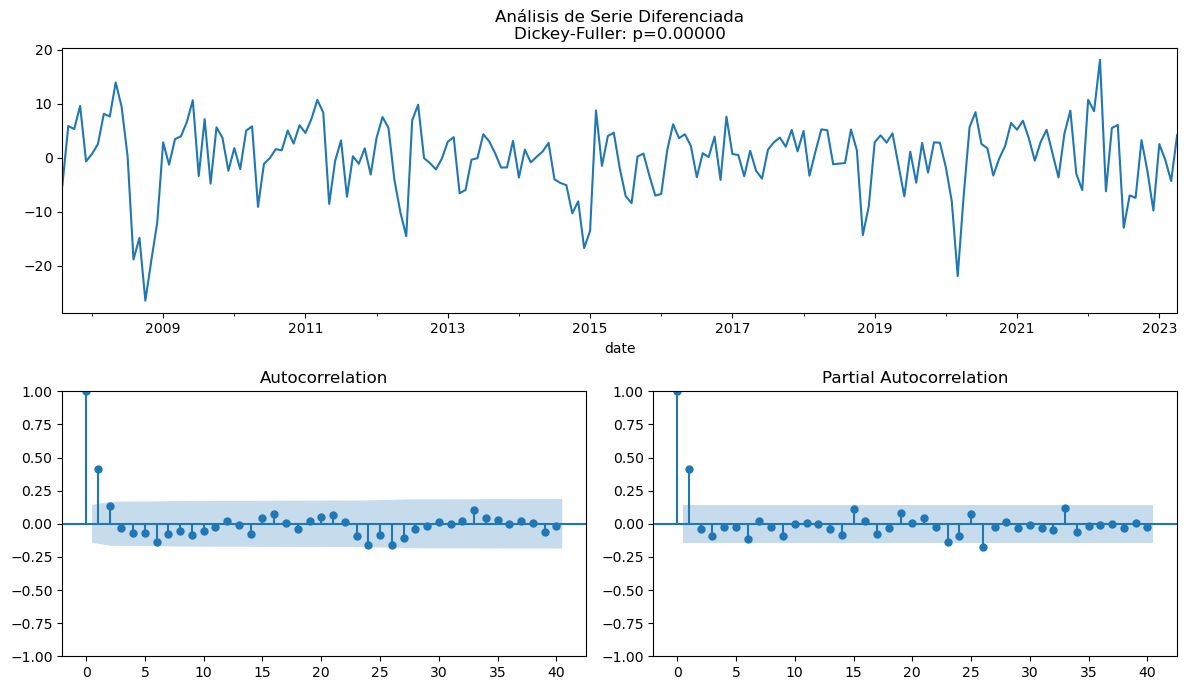

In [351]:
tsplot(df_train_b_diff, lags=40, title='Análisis de Serie Diferenciada')

In [352]:
# Ajuste de modelo SARIMA
order = (1,1,1)  # Parámetros ARIMA
seasonal_order = (1, 1, 1, 12)  # Parámetros SARIMA (P, D, Q, m)

model_SARIMA = SARIMAX(df_train_b_diff, order=order, seasonal_order=seasonal_order)

model_SARIMA_fit=model_SARIMA.fit()

print(model_SARIMA_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Diferenciada   No. Observations:                  189
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -585.119
Date:                            Thu, 23 May 2024   AIC                           1180.239
Time:                                    15:02:15   BIC                           1196.091
Sample:                                08-01-2007   HQIC                          1186.669
                                     - 04-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4158      0.077      5.378      0.000       0.264       0.567
ma.L1         -0.9998      4.032   

In [353]:
# Generación de predicciones
forecast = model_SARIMA_fit.forecast(steps=len(df_test_b['close']),alpha=alpha)

In [354]:
# Añadir predicciones al dataframe de prueba
df_train_b['model_SARIMA'] = df_train_b['close'] + model_SARIMA_fit.fittedvalues
df_test_b['model_SARIMA'] = df_test_b['close'] + forecast

In [355]:
brent_mse_sarima  = mean_squared_error(df_test_b['close'], df_test_b['model_SARIMA'])
brent_rmse_sarima = np.sqrt(brent_mse_sarima)

print("El Mean Squared Error (MSE) es:", brent_mse_sarima)

print("El Root Mean Squared Error (RMSE) es:",brent_rmse_sarima)

# guardamos el rmse
performance_df_b.loc[3] = ['SARIMA', brent_rmse_sarima]
performance_df_b

El Mean Squared Error (MSE) es: 3.997743295146941
El Root Mean Squared Error (RMSE) es: 1.9994357441905806


Model       RMSE
0           Tendencia con Transformación Logarítmica  22.581632
1  Transformación Logarítmica + Estacionalidad Me...  22.562356
2                                              ARIMA   1.771096
3                                             SARIMA   1.999436

## 7.5 Evaluación de los modelos

In [356]:
# Armamos un dataframe que unifique todos los resultados

performance_final = pd.concat([brent_resultados, performance_df_b], axis=0)
performance_final

Model       RMSE
0                    Reg Lineal Simple con timeIndex  20.396584
1                 RL Múltiple con timeIndex y volume  11.510483
2                        RL Múltiple con timeIndex^2  12.449078
3  RL Múltiple con producto entre timeIndex y vol...  10.820649
4                       RL Múltiple + estacionalidad  12.065263
0           Tendencia con Transformación Logarítmica  22.581632
1  Transformación Logarítmica + Estacionalidad Me...  22.562356
2                                              ARIMA   1.771096
3                                             SARIMA   1.999436

# 8 Comparación WTI-BRENT

In [357]:
dif_wti_brent = (brent_ARIMA - wti_ARIMA)

In [358]:
wti_brent = (brent_ARIMA - wti_ARIMA)/wti_ARIMA *100
wti_brent

date
2023-05-01    4.629895
2023-06-01    7.830419
2023-07-01    7.569081
2023-08-01    6.673477
2023-09-01    5.651379
2023-10-01    5.828708
2023-11-01    8.342318
2023-12-01    9.646219
2024-01-01    9.604735
2024-02-01    8.840226
2024-03-01    7.486243
2024-04-01    7.461336
Freq: MS, Name: model_ARIMA, dtype: float64

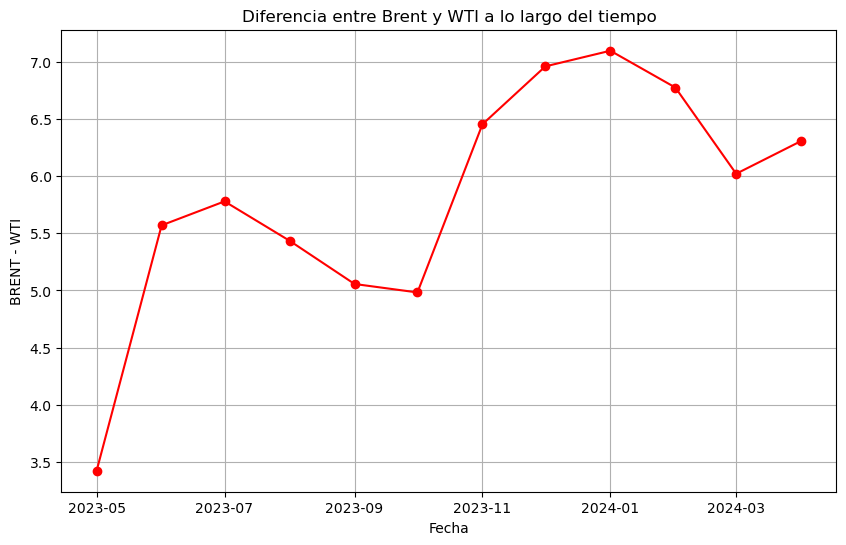

In [359]:
# Creamos el gráfico de línea representando la resta entre BRENT y WTI
plt.figure(figsize=(10, 6))
plt.plot(dif_wti_brent.index, dif_wti_brent.values, marker='o', linestyle='-', color='r')
plt.title('Diferencia entre Brent y WTI a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('BRENT - WTI')
plt.grid(True)

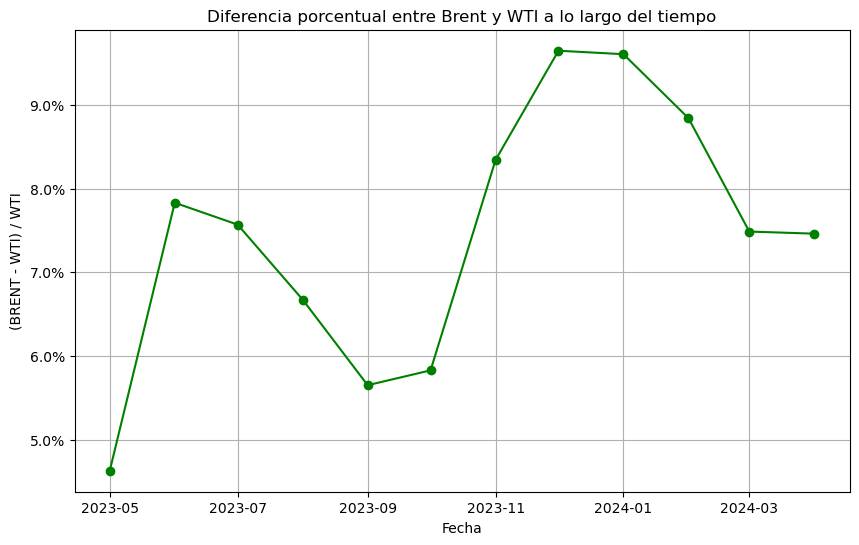

In [361]:
# Creamos el gráfico de línea representando en qué porcentaje BRENT es mayor a WTI
plt.figure(figsize=(10, 6))
plt.plot(wti_brent.index, wti_brent.values, marker='o', linestyle='-', color='g')
plt.title('Diferencia porcentual entre Brent y WTI a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('(BRENT - WTI) / WTI')
plt.grid(True)

# Formateamos el eje y como porcentaje
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))


La comparación entre los modelos predictivos de ambos activos nos sugieren que en el lapso del año el spread entre el Brent y WTI oscilaría entre los 3.5 y los 7 dólares, tocando su máximo para el octavo mes (enero de 2024). Es decir que el precio del barril del Brent mantendría una prima por sobre el de WTI del orden del 5 al 9.5 por ciento. 

El análisis resultante sugiere que el mayor rendimiento de renta variable se alcanzaría  manteniendo el título del Brent hasta enero de 2024.